In [466]:
# from ff_energy.simulations import dipole as dipole
from ff_energy.simulations.dipole import dipole_dcm
from ff_energy.simulations.dipole import *
%load_ext autoreload
%autoreload 2

XLIM = (3686-50, 3686+50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
xs = []
ys = []
with open("/home/boittier/Downloads/waterIR.jdx") as f:
    lines = f.readlines()[37:-2]
    for line in lines:
        x, y = [float(_) for _ in line.split()][:2]
        xs.append(x)
        ys.append(1 - y)
water_exp_spectrum = [xs, ys]


In [468]:
from pint import UnitRegistry
import warnings

# ignore the casting errors for units
warnings.simplefilter("ignore")
ureg = UnitRegistry()


volume = 59468.16964 * ureg("angstrom**3")
volume

59468.16964 <Unit('angstrom ** 3')>

In [469]:
Boltzmann_const = 1.38064852 * 10 ** (-23) * ureg("J / K")
Boltzmann_const

1.38064852e-23 <Unit('joule / kelvin')>

In [470]:
file = "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/fort.14"
import numpy as np

dipole_xyz_sequence = np.genfromtxt(file)

In [471]:
# M.mean()

In [595]:


angstrom_charge_to_debye = 0.2081943

vacuum_perm = (8.8541878188 * 10**(-12)) * ureg("F/m")
vacuum_perm.to("e^2 / ( (kcal) * angstrom)")

1.4431770654433121e+20 <Unit('elementary_charge ** 2 / angstrom / kilocalorie')>

In [473]:
def perm(M, V, T):
    T = T * ureg("K")
    M = M * ureg("e angstrom")
    MM = (np.mean(M**2) - np.mean(M)**2)
    print(MM)
    const = (4*np.pi) / (3 * vacuum_perm * V * Boltzmann_const * T)
    print(const)
    return 1 + (const * MM)

def perm2(M, V, T):
    T = T * ureg("K")
    M = M * ureg("e angstrom")
    return np.mean(M**2) * 1/(Boltzmann_const * T) / (3*vacuum_perm*V)

def perm3(M, V, T):
    T = T * ureg("K")
    M = M * ureg("e angstrom")
    return 1 + ( ( np.mean(M**2) - np.mean(M)**2 ) / (3 * vacuum_perm * V * Boltzmann_const * T)) 

In [474]:
M = np.linalg.norm(dipole_xyz_sequence, axis=1)
# M = M * ureg("e angstrom")
# M = M.to("D")
# np.mean(M)**2

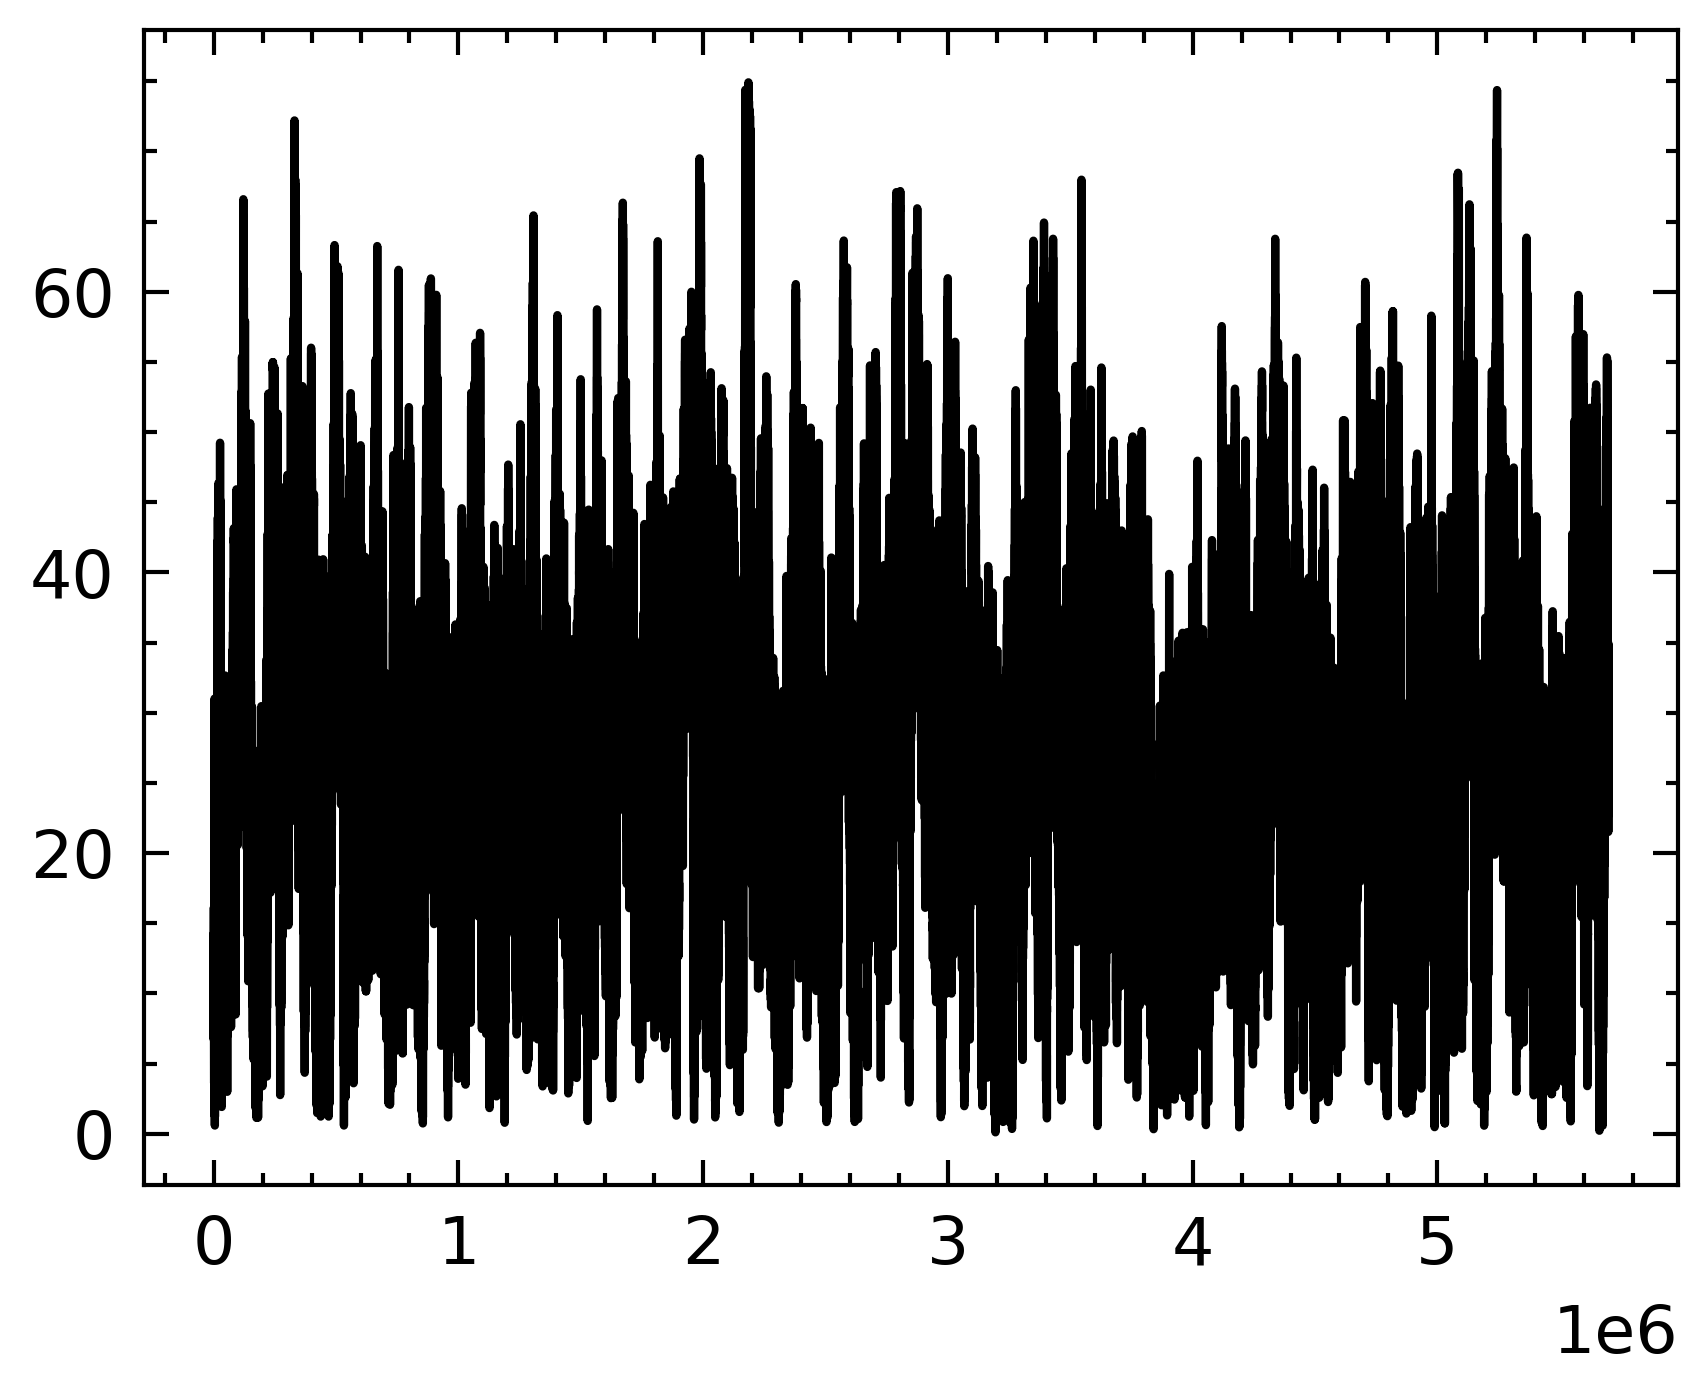

In [475]:
plt.plot(M)

In [476]:
M.shape, M[::100000].shape

((5699939,), (57,))

In [477]:
p = perm(M, volume, 298)

137.5560197157265 angstrom ** 2 * elementary_charge ** 2
1.9335522468857912e+27 meter / angstrom ** 3 / farad / joule


In [478]:
p

69.27414967484985 <Unit('dimensionless')>

In [479]:
perm2(M, volume, 300)

1.3529606517771818e+29 <Unit('elementary_charge ** 2 * meter / angstrom / farad / joule')>

In [511]:
perm3(M, volume, 300) * 4*np.pi/3

26.79511976379224 <Unit('dimensionless')>

Average dipole:  131.33491157263575


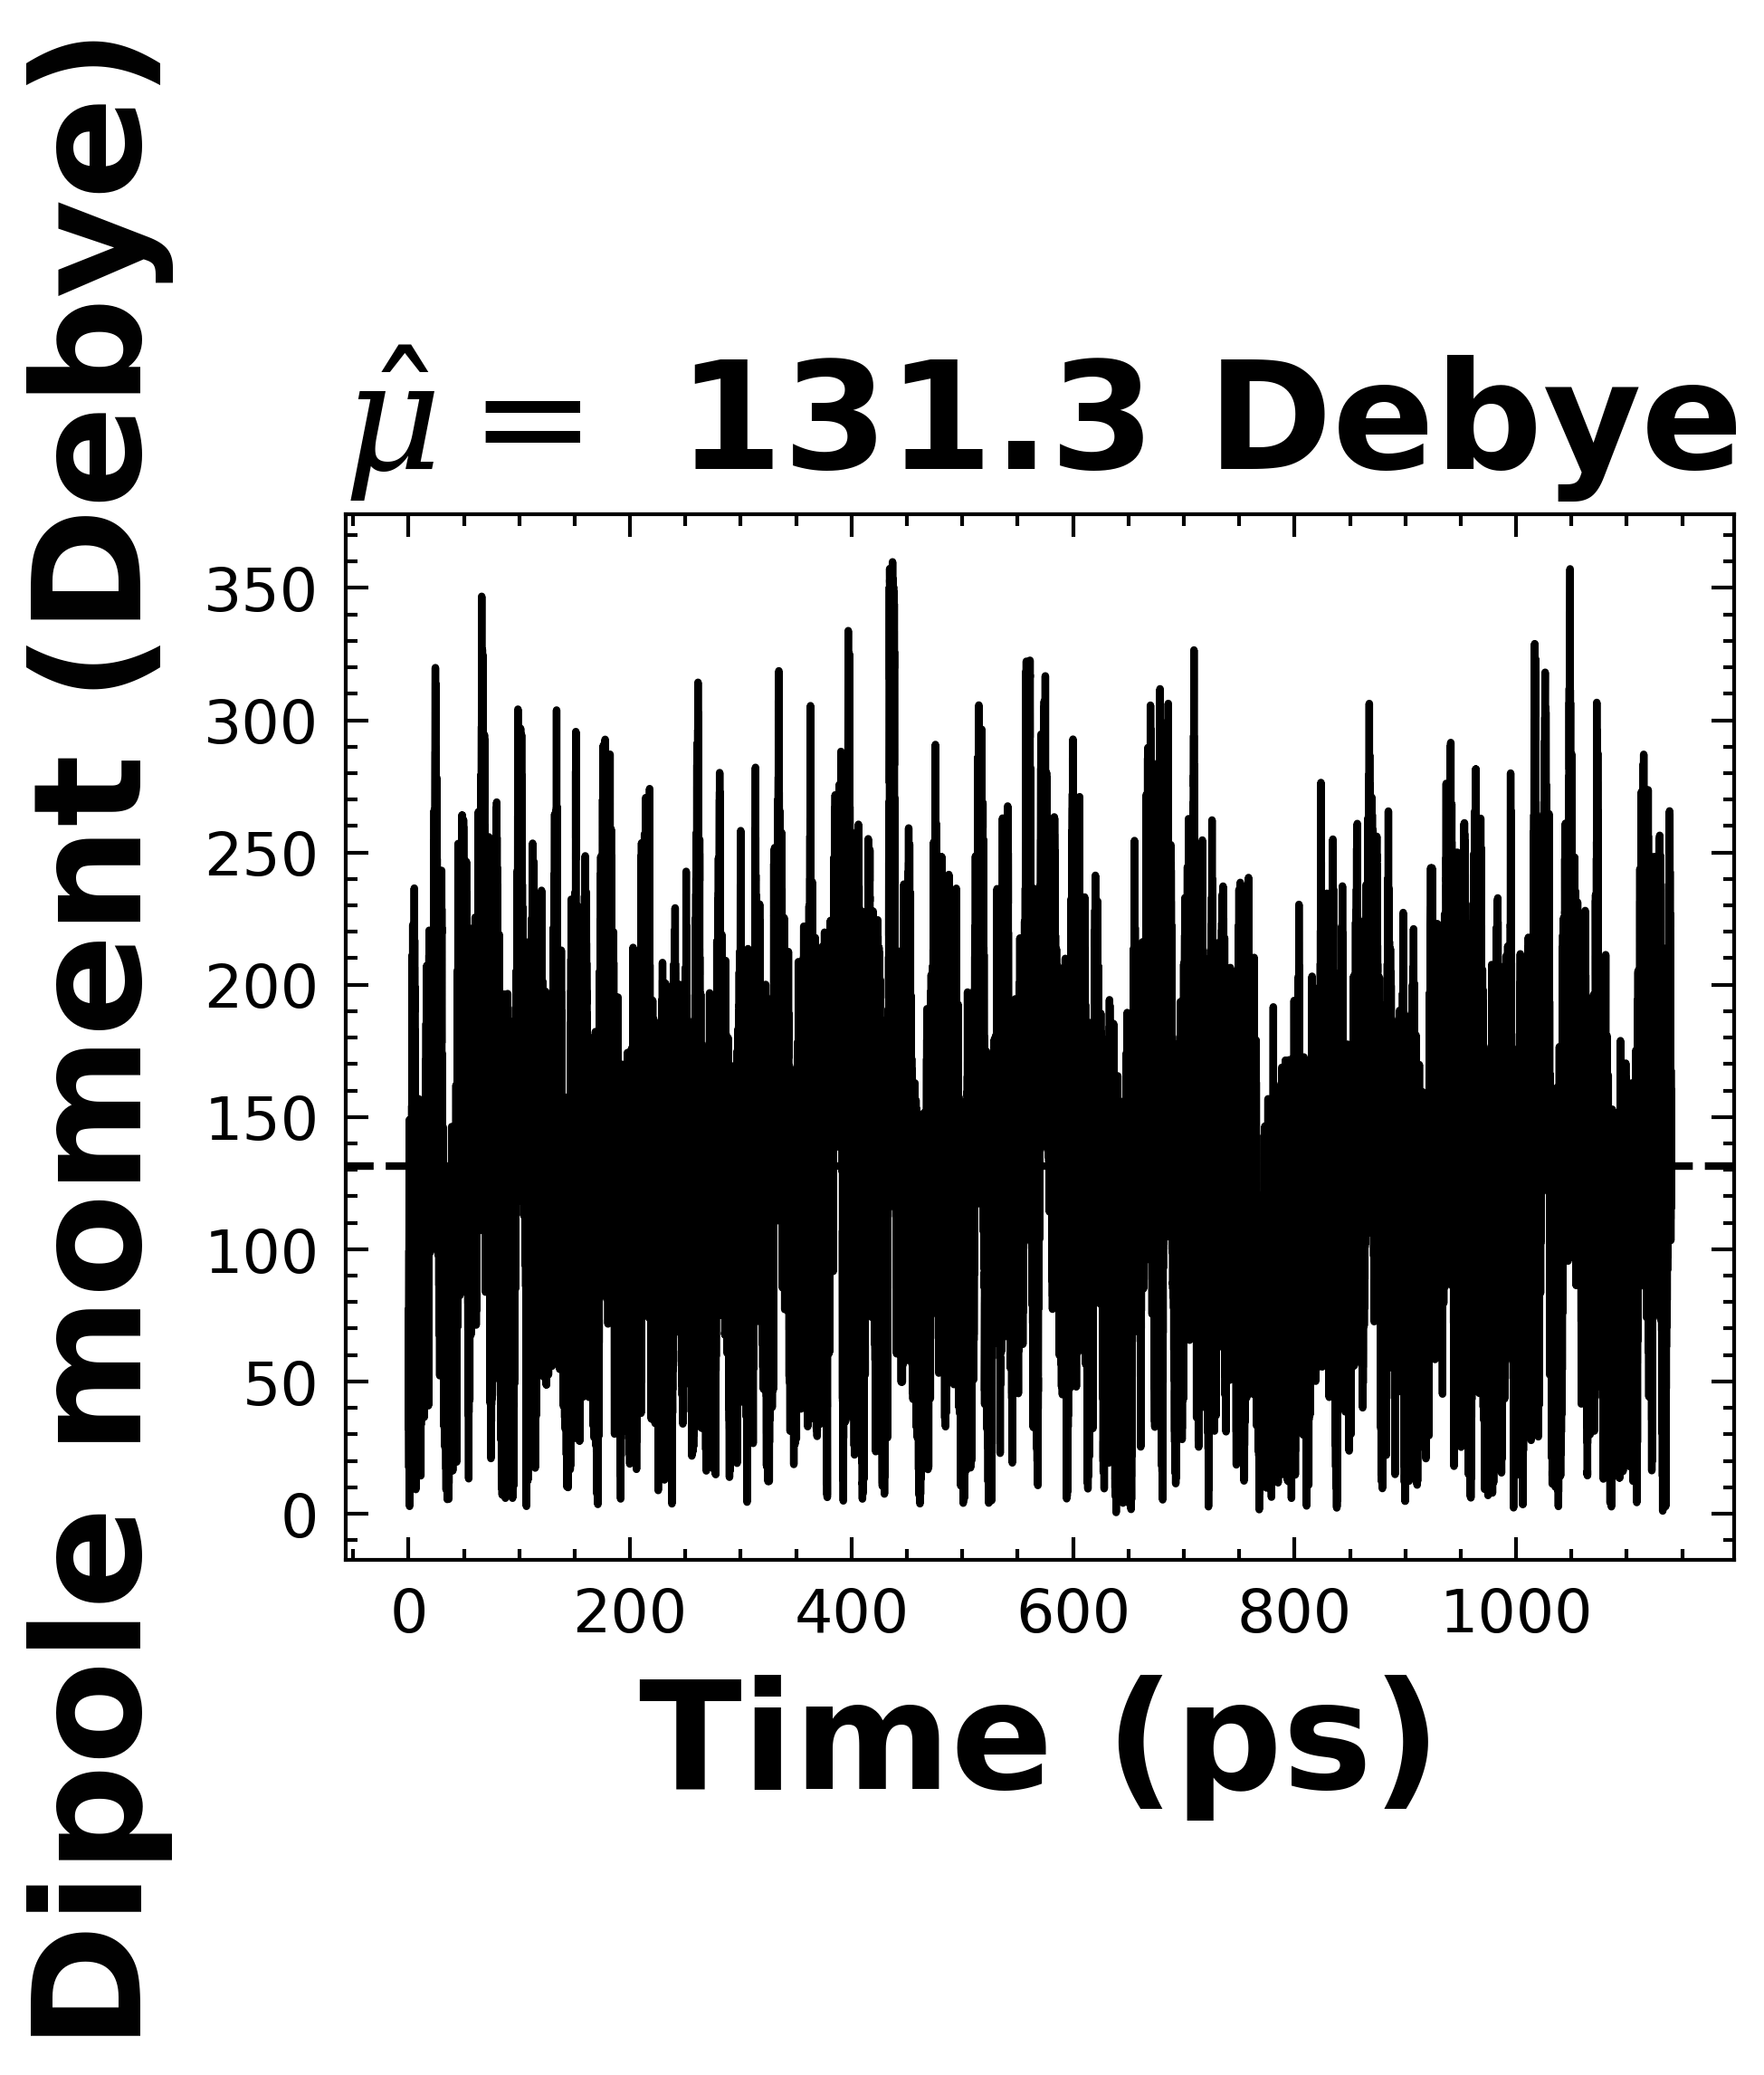

Nframes:  5699939


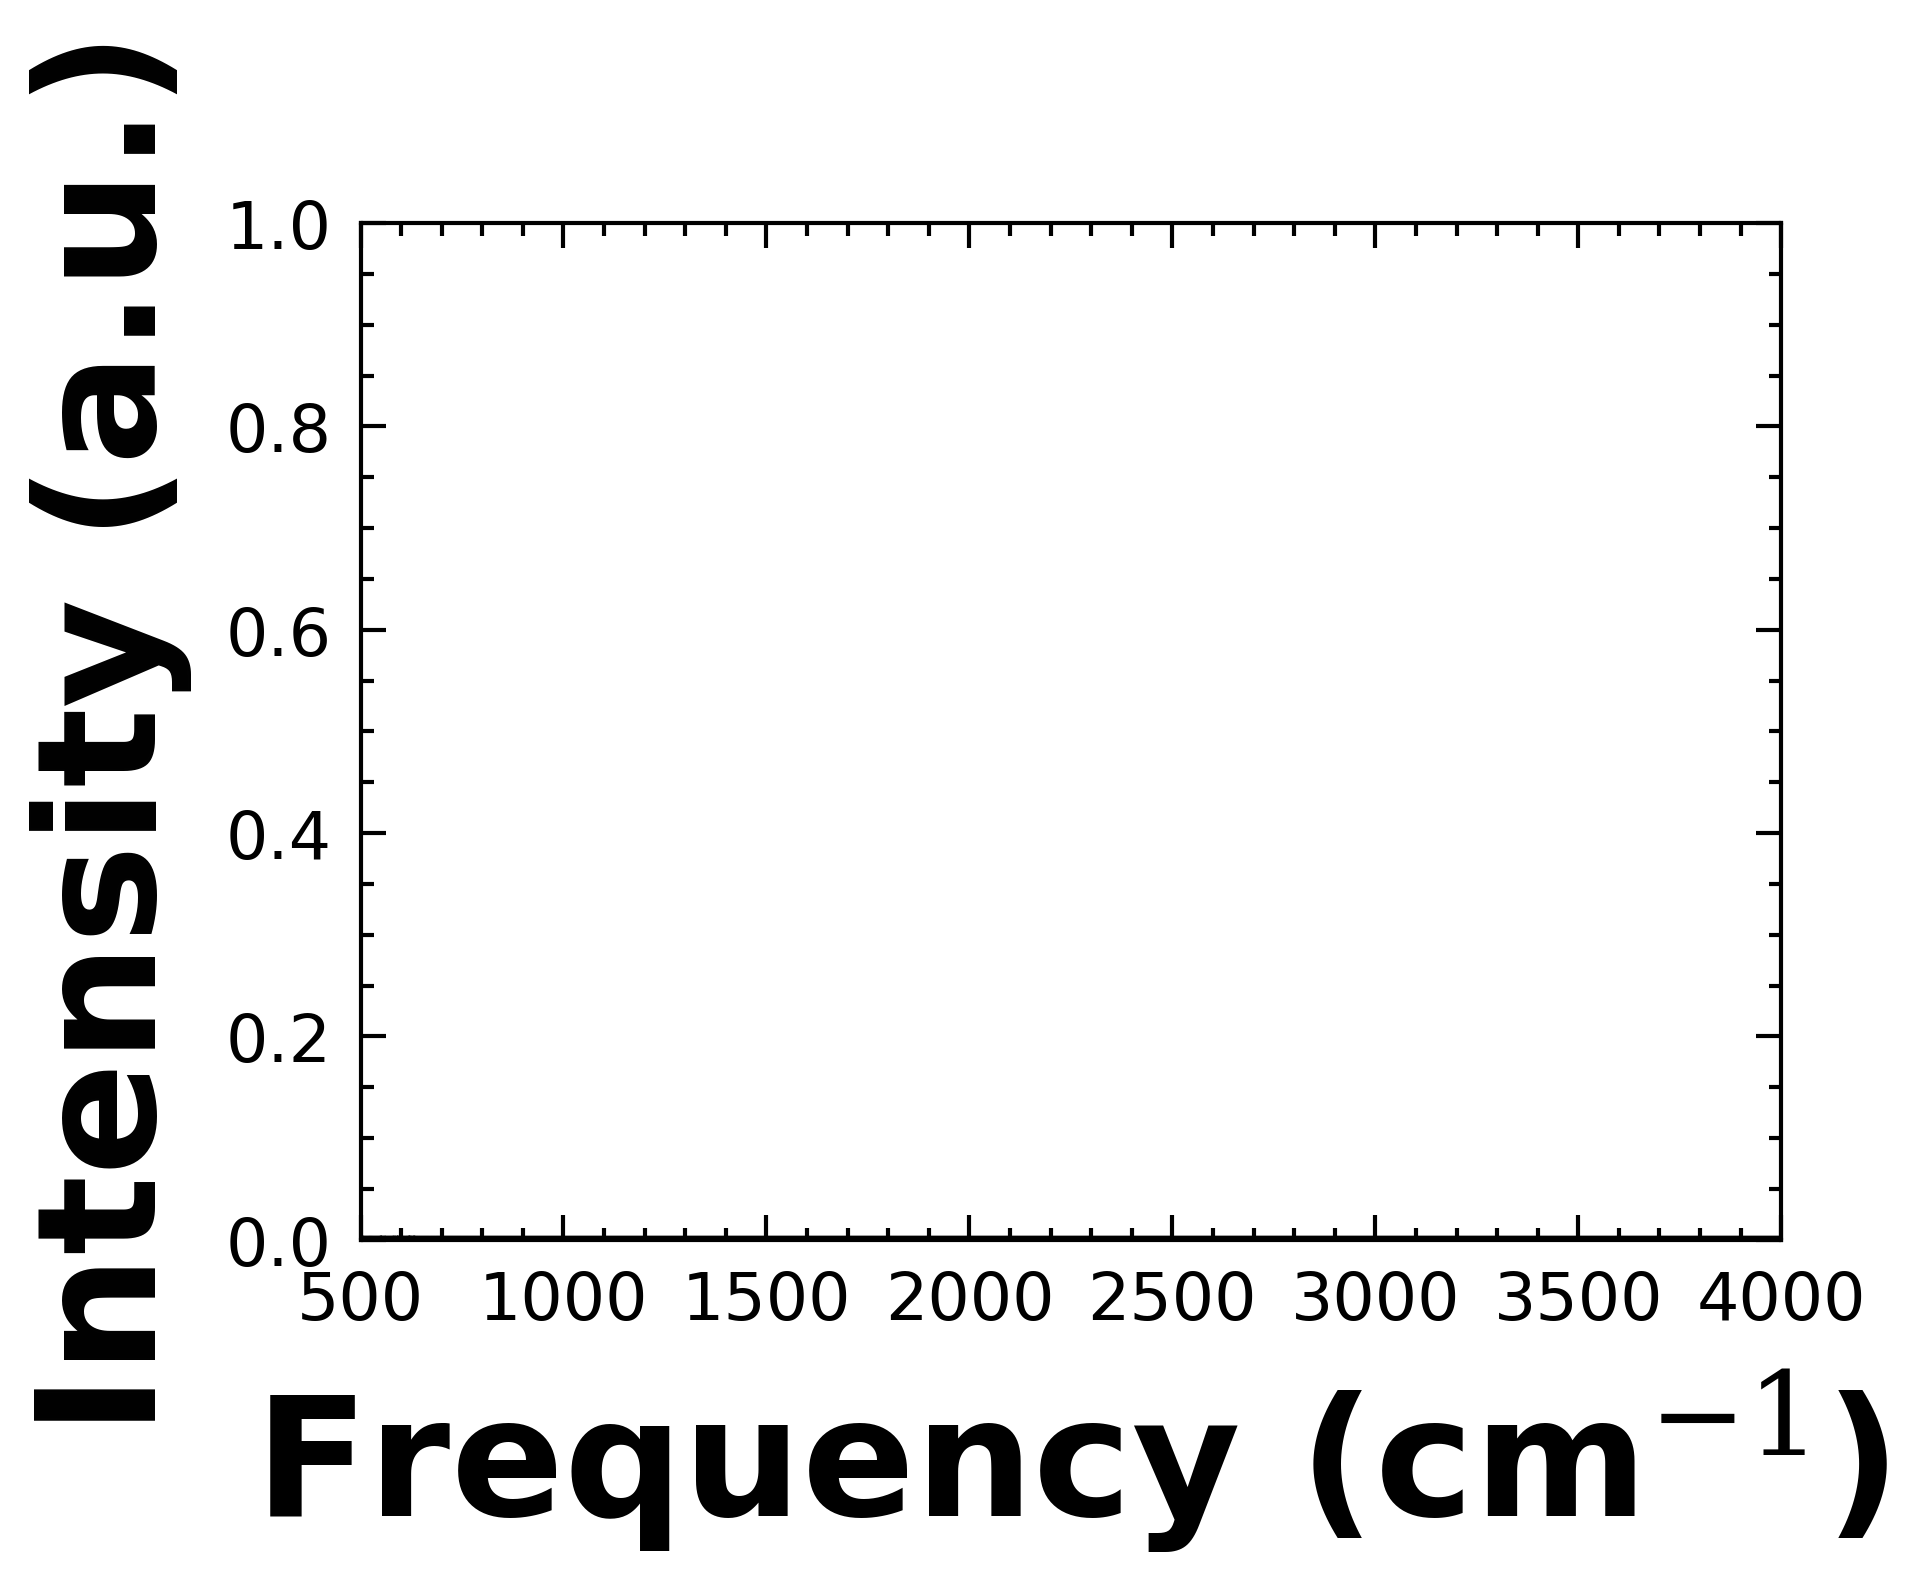

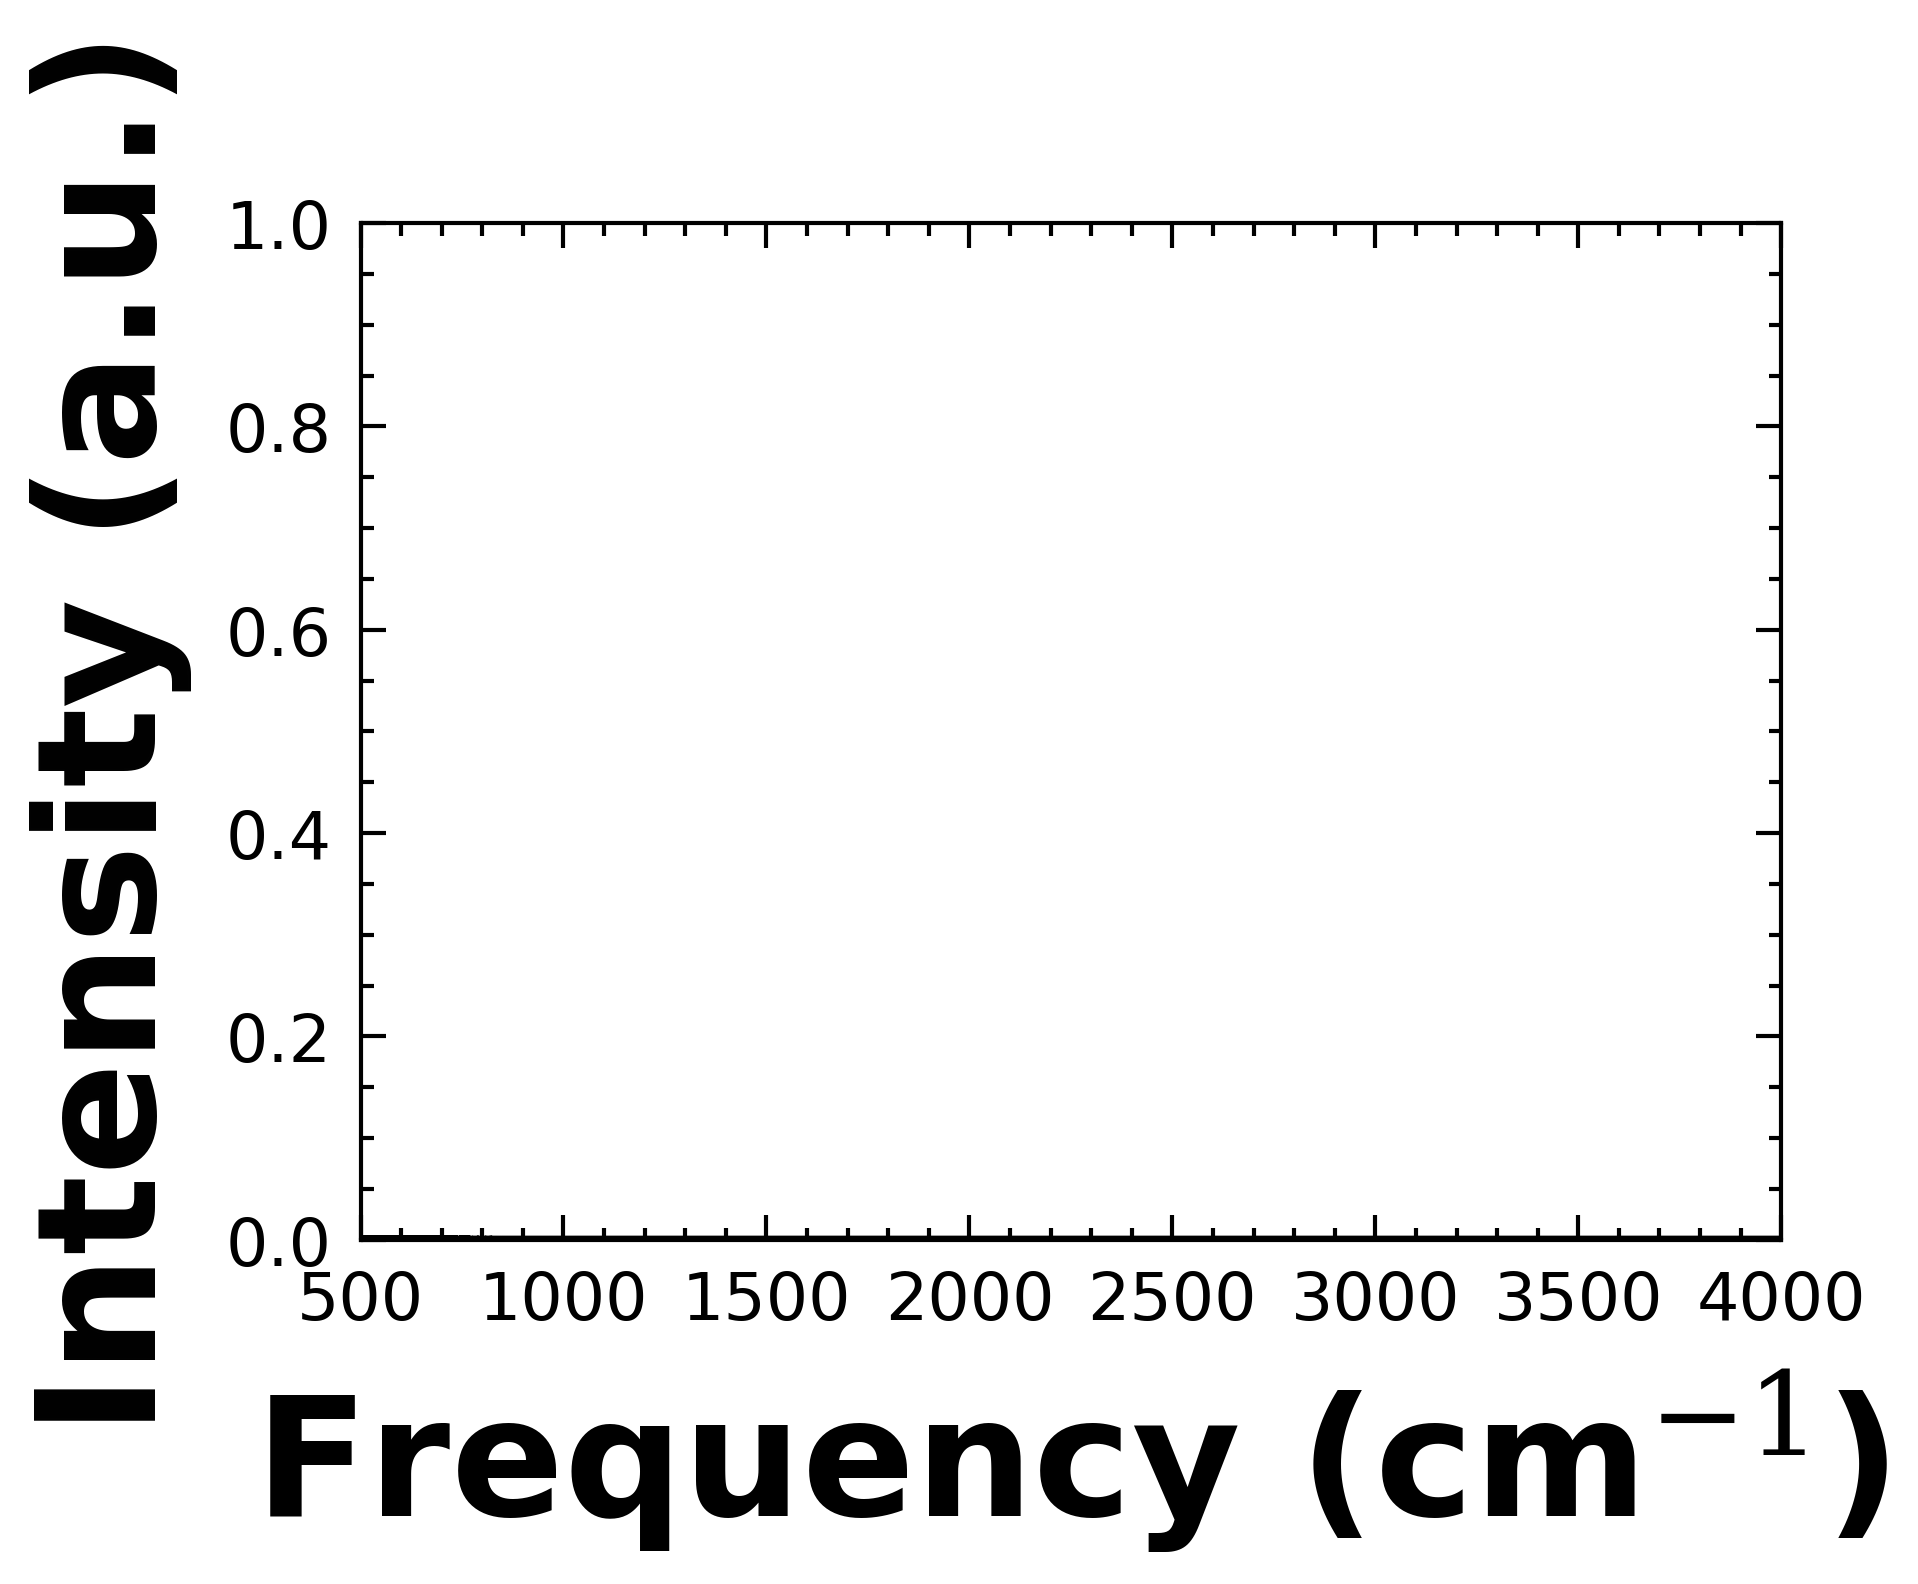

In [481]:
timestep = 0.0002
save_freq = 1
effective_timestep = timestep * save_freq

# file = "/home/boittier/pcbach/kmdcm_nn_water1/fort.15"
file = "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/fort.14"
# file = "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a_vdw3/fort.14"
# file = "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a_vdw2/fort.14"
# file = "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/fort.14_ir_cpt"
# file = "/home/boittier/pcbach/waterlj/kjobbayes2-60-336a8abb-f9c3-4fd0-baa0-0d609843c71e/fort.14"

# file = "/home/boittier/pcbehome/kmdcm_nn_water1/fort.15"
# file = "/home/boittier/pcbach/kmdcm_water_sim_rkhs_copy/ir.dat"
# file = "/home/boittier/pcbach/kmdcm_water_sim_rkhs/ir.dat"

dipole_dcm("MDCM-nn", file, effective_timestep=effective_timestep, NSKIP=0)
plt.show()
_ = plot_spectra(None, None, filename="MDCM-nn", csv="MDCM-nn.csv", Nsmooth=1)
# plot_spectra(None, None, filename="kMDCM_liquid_OH", csv="kMDCM_liquid.csv", Nsmooth=50, xlim=(3600,3900), axvlines=[3686])


In [482]:
# _df["spectra"].describe()

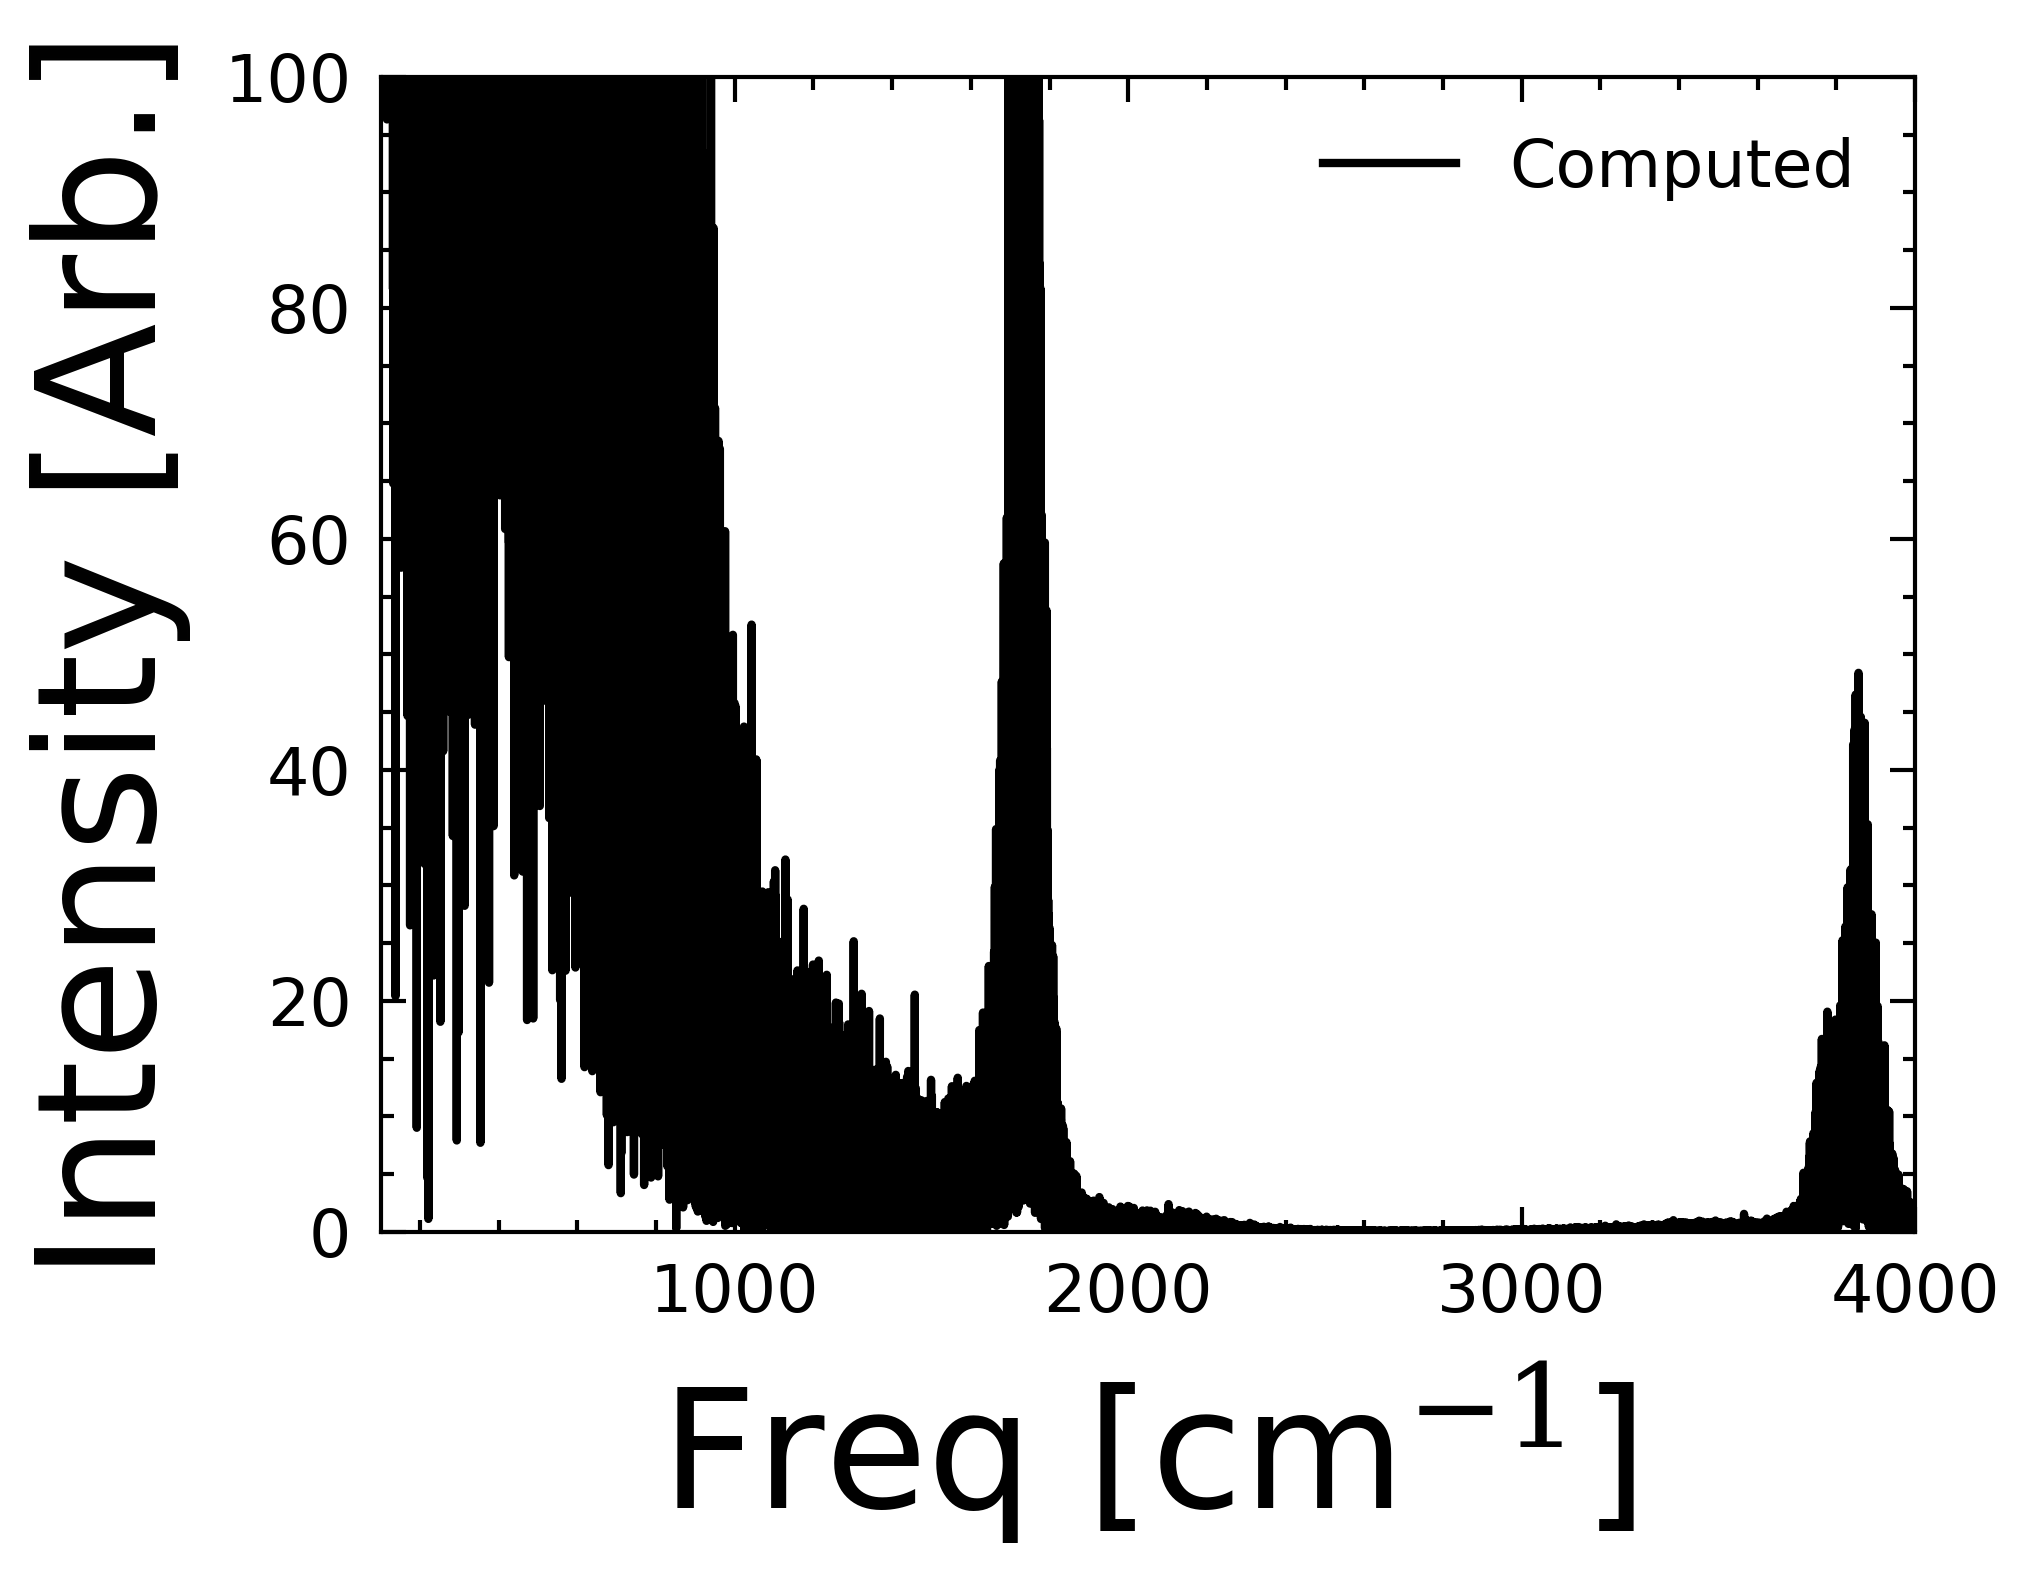

In [483]:
_df = pd.read_csv("MDCM-nn.csv")
_df["Computed"] = _df["spectra"] 
_df.plot("freq", "Computed")
plt.xlim(100, 4000)
# plt.plot(water_exp_spectrum[0], np.array(water_exp_spectrum[1])*0.5, label="Exp.")
# plt.xlim(1000,4000)
# plt.legend()
plt.ylim(0,100)
plt.xlabel("Freq [cm$^{-1}$]", fontsize=20)
plt.ylabel("Intensity [Arb.]", fontsize=20)
plt.savefig("IR.pdf", bbox_inches="tight")
# plt.xlim(1500, 1800)

In [484]:
from scipy.signal import find_peaks

peak_pos = find_peaks(_df["Computed"])

peaks = _df.iloc[peak_pos[0]]

peaks_sorted = peaks[peaks["Computed"] > 0]
_ = peaks_sorted[peaks_sorted["freq"] < 2000]
_[_["freq"] > 1600].sort_values("Computed")

,freq,spectra,Computed
66443,1944.143541,0.155913,0.155913
65149,1906.280685,0.159054,0.159054
67260,1968.049223,0.159101,0.159101
66138,1935.219143,0.186566,0.186566
65976,1930.478970,0.204718,0.204718
...,...,...,...
59850,1751.230241,215.194958,215.194958
59607,1744.119983,220.639157,220.639157
59478,1740.345401,226.617829,226.617829
59195,1732.064730,228.709287,228.709287


In [485]:
1.77, 1731
1.765, 1735
1.76, 1746

(1.76, 1746)

In [486]:
freq = _df["freq"] 
# temperature in K
Ti = 300
# Quantum correction factor qcf
Kb = 3.1668114e-6  # Boltzmann constant in atomic units (Hartree/K)
beta = 1.0 / (Kb / float(Ti))  # atomic units
hbar = 1.0  # atomic units
const = beta * hbar  # atomic units
cminvtoau = 1.0 / 2.1947e7  # inv cm to atomic units

qcf = np.tanh(const * freq * cminvtoau / 2.0)

In [487]:
_df

,freq,spectra,Computed
0,0.000000,7.801226e+06,7.801226e+06
1,0.029260,6.071539e+06,6.071539e+06
2,0.058521,5.771070e+06,5.771070e+06
3,0.087781,5.277999e+06,5.277999e+06
4,0.117041,1.838884e+06,1.838884e+06
...,...,...,...
2849965,83390.892128,2.378672e-05,2.378672e-05
2849966,83390.921388,3.192073e-05,3.192073e-05
2849967,83390.950649,1.525206e-05,1.525206e-05
2849968,83390.979909,1.790690e-06,1.790690e-06


In [488]:
kb = 0.695 * ureg("cm^-1 K^-1")
kb

0.695 <Unit('1 / centimeter / kelvin')>

In [489]:
T = 300 * ureg("K")

In [490]:
beta = 1/(kb * T)
import ase

In [491]:
c = ase.units._c * ureg("m/s")
c.to("cm/s")

29979245800.0 <Unit('centimeter / second')>

In [492]:
hbar = 5.29 * 10**-12 * ureg("cm^-1 s")
hbar

5.29e-12 <Unit('second / centimeter')>

In [493]:
import ase 
twopiomega = 2 * np.pi * _df["freq"] 
exp_corr = (1 - np.exp(-beta * hbar.magnitude * _df["freq"] ))
three_h_c_v = 3 * hbar * c.to("cm/s").magnitude * volume.to("cm**3").magnitude

In [494]:
three_h_c_v

2.829320858487974e-20 <Unit('second / centimeter')>

In [495]:
volume.to("cm^3").magnitude

5.946816964e-20

In [496]:
(twopiomega * exp_corr)/three_h_c_v

0          0.000000e+00
1          5.049926e+03
2          1.875687e+04
3          4.328508e+04
4          7.791315e+04
               ...     
2849965    3.918181e+16
2849966    3.918184e+16
2849967    3.918187e+16
2849968    3.918189e+16
2849969    3.918192e+16
Name: freq, Length: 2849970, dtype: float64

In [497]:
freq[:300].dropna()

0      0.000000
1      0.029260
2      0.058521
3      0.087781
4      0.117041
         ...   
295    8.631795
296    8.661055
297    8.690315
298    8.719576
299    8.748836
Name: freq, Length: 300, dtype: float64

In [498]:
# spectraCor = _df["spectra"]  * (2*np.pi/3 * freq * (1 - np.exp(-hbar*freq / beta)))  * qcf


spectraCor = _df["spectra"]  * (twopiomega * exp_corr)/three_h_c_v
# spectraCor = (_df["spectra"]  * qcf * _df["spectra"]  
#               / (freq * (1 - np.exp(-hbar*freq / beta))))**0.5
FONTSIZE = 10

plt.style.use(["science", "no-latex", "ieee"])
ir_df = pd.DataFrame({"freq": freq, "Computed": spectraCor})



In [499]:
ir_df["freq"]

0              0.000000
1              0.029260
2              0.058521
3              0.087781
4              0.117041
               ...     
2849965    83390.892128
2849966    83390.921388
2849967    83390.950649
2849968    83390.979909
2849969    83391.009169
Name: freq, Length: 2849970, dtype: float64

In [500]:
n_roll = 800

intensity = ir_df.rolling(n_roll).mean()["Computed"]/ir_df.rolling(n_roll).mean()["Computed"].max()

In [501]:
freq = ir_df.rolling(n_roll).mean()["freq"]
freq

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
               ...     
2849965    83379.202630
2849966    83379.231890
2849967    83379.261150
2849968    83379.290411
2849969    83379.319671
Name: freq, Length: 2849970, dtype: float64

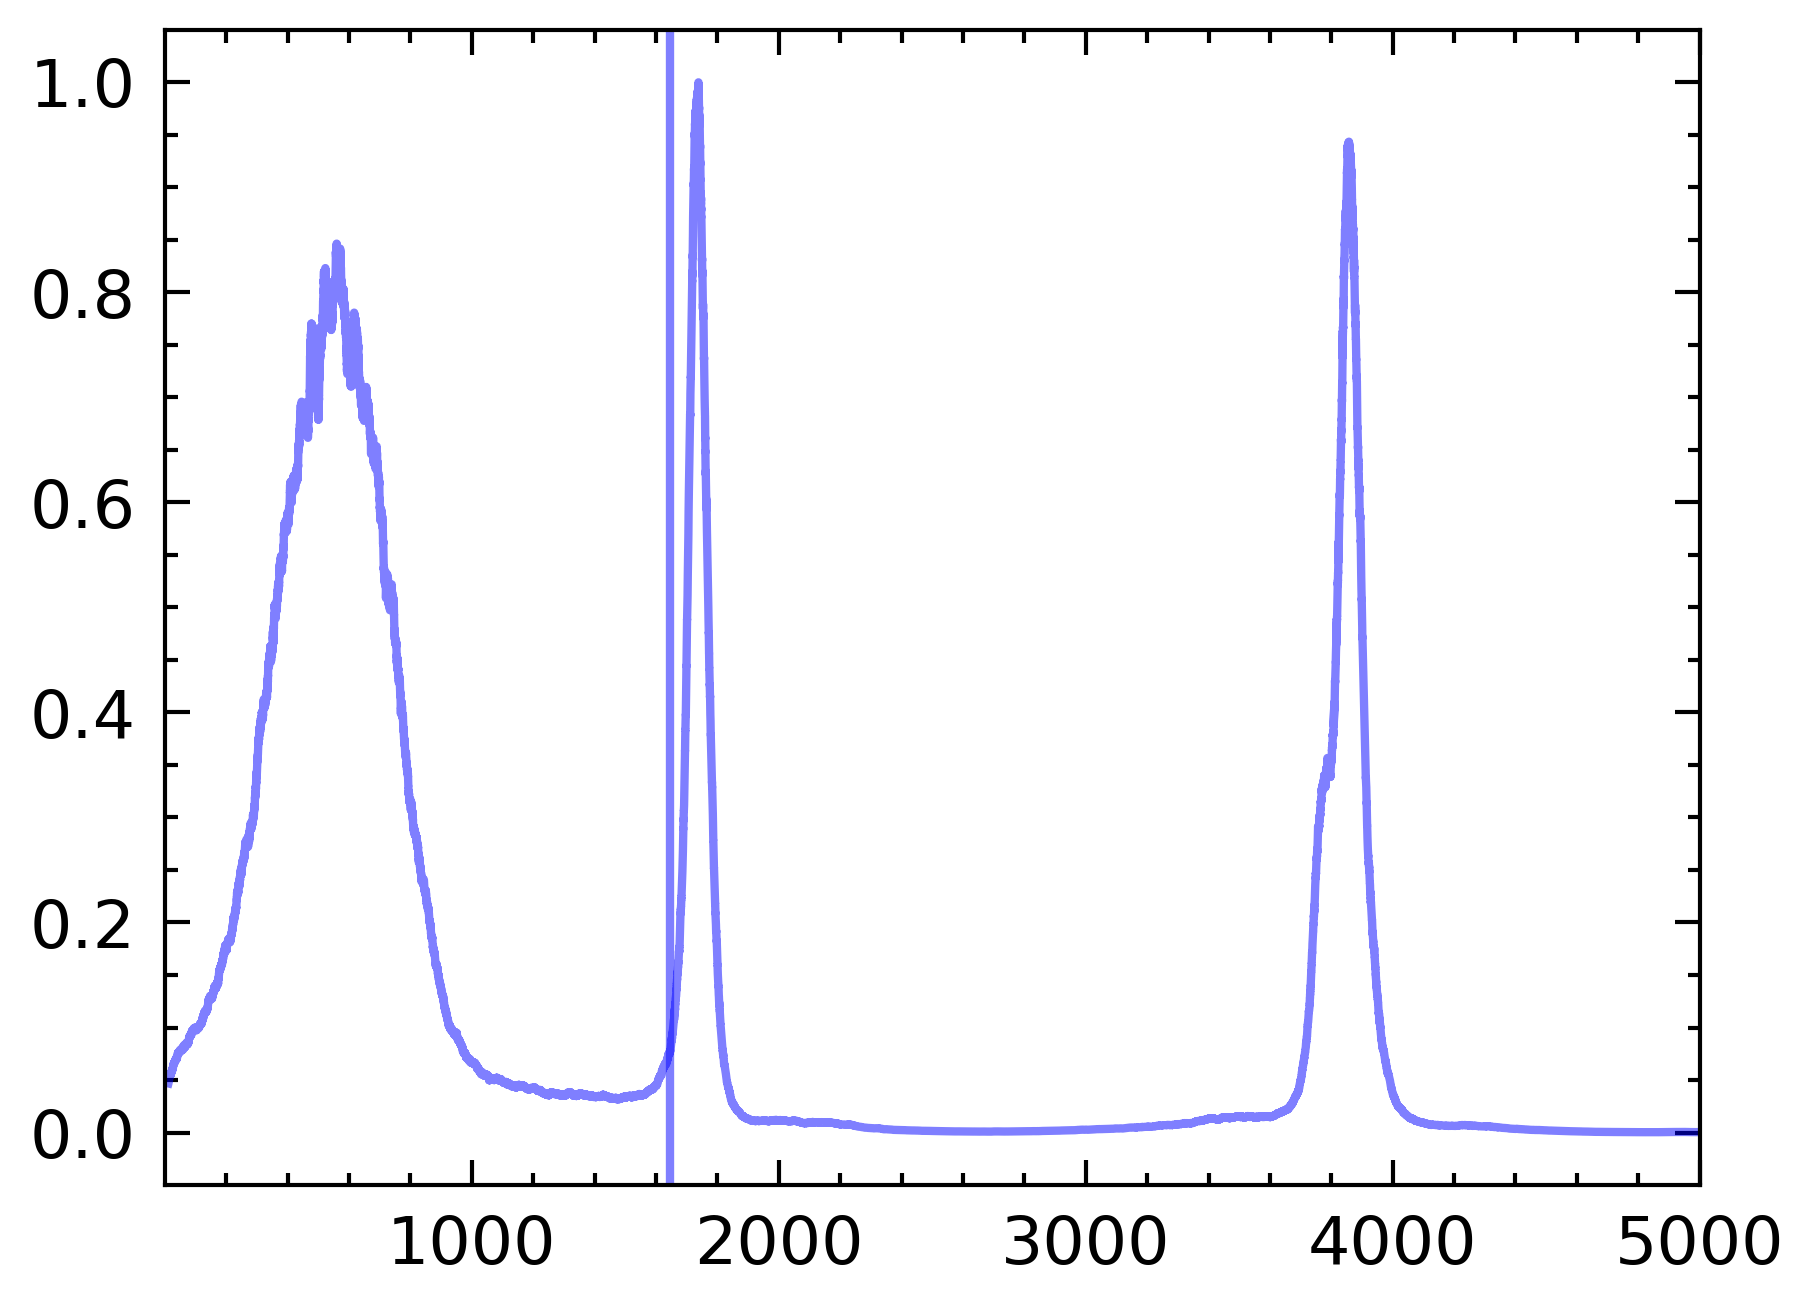

In [502]:
plt.plot(freq, intensity, color="blue", 
                            label="kMDCM-NN", alpha=0.5)
# plt.xlim(1, 1000)
plt.xlim(1, 5000)
plt.axvline(1646, color="b",linestyle="-", alpha=0.5)

In [503]:
# spectraCor = _df["spectra"]  * qcf 

In [504]:
spectraCor.max()

5073524008484444.0

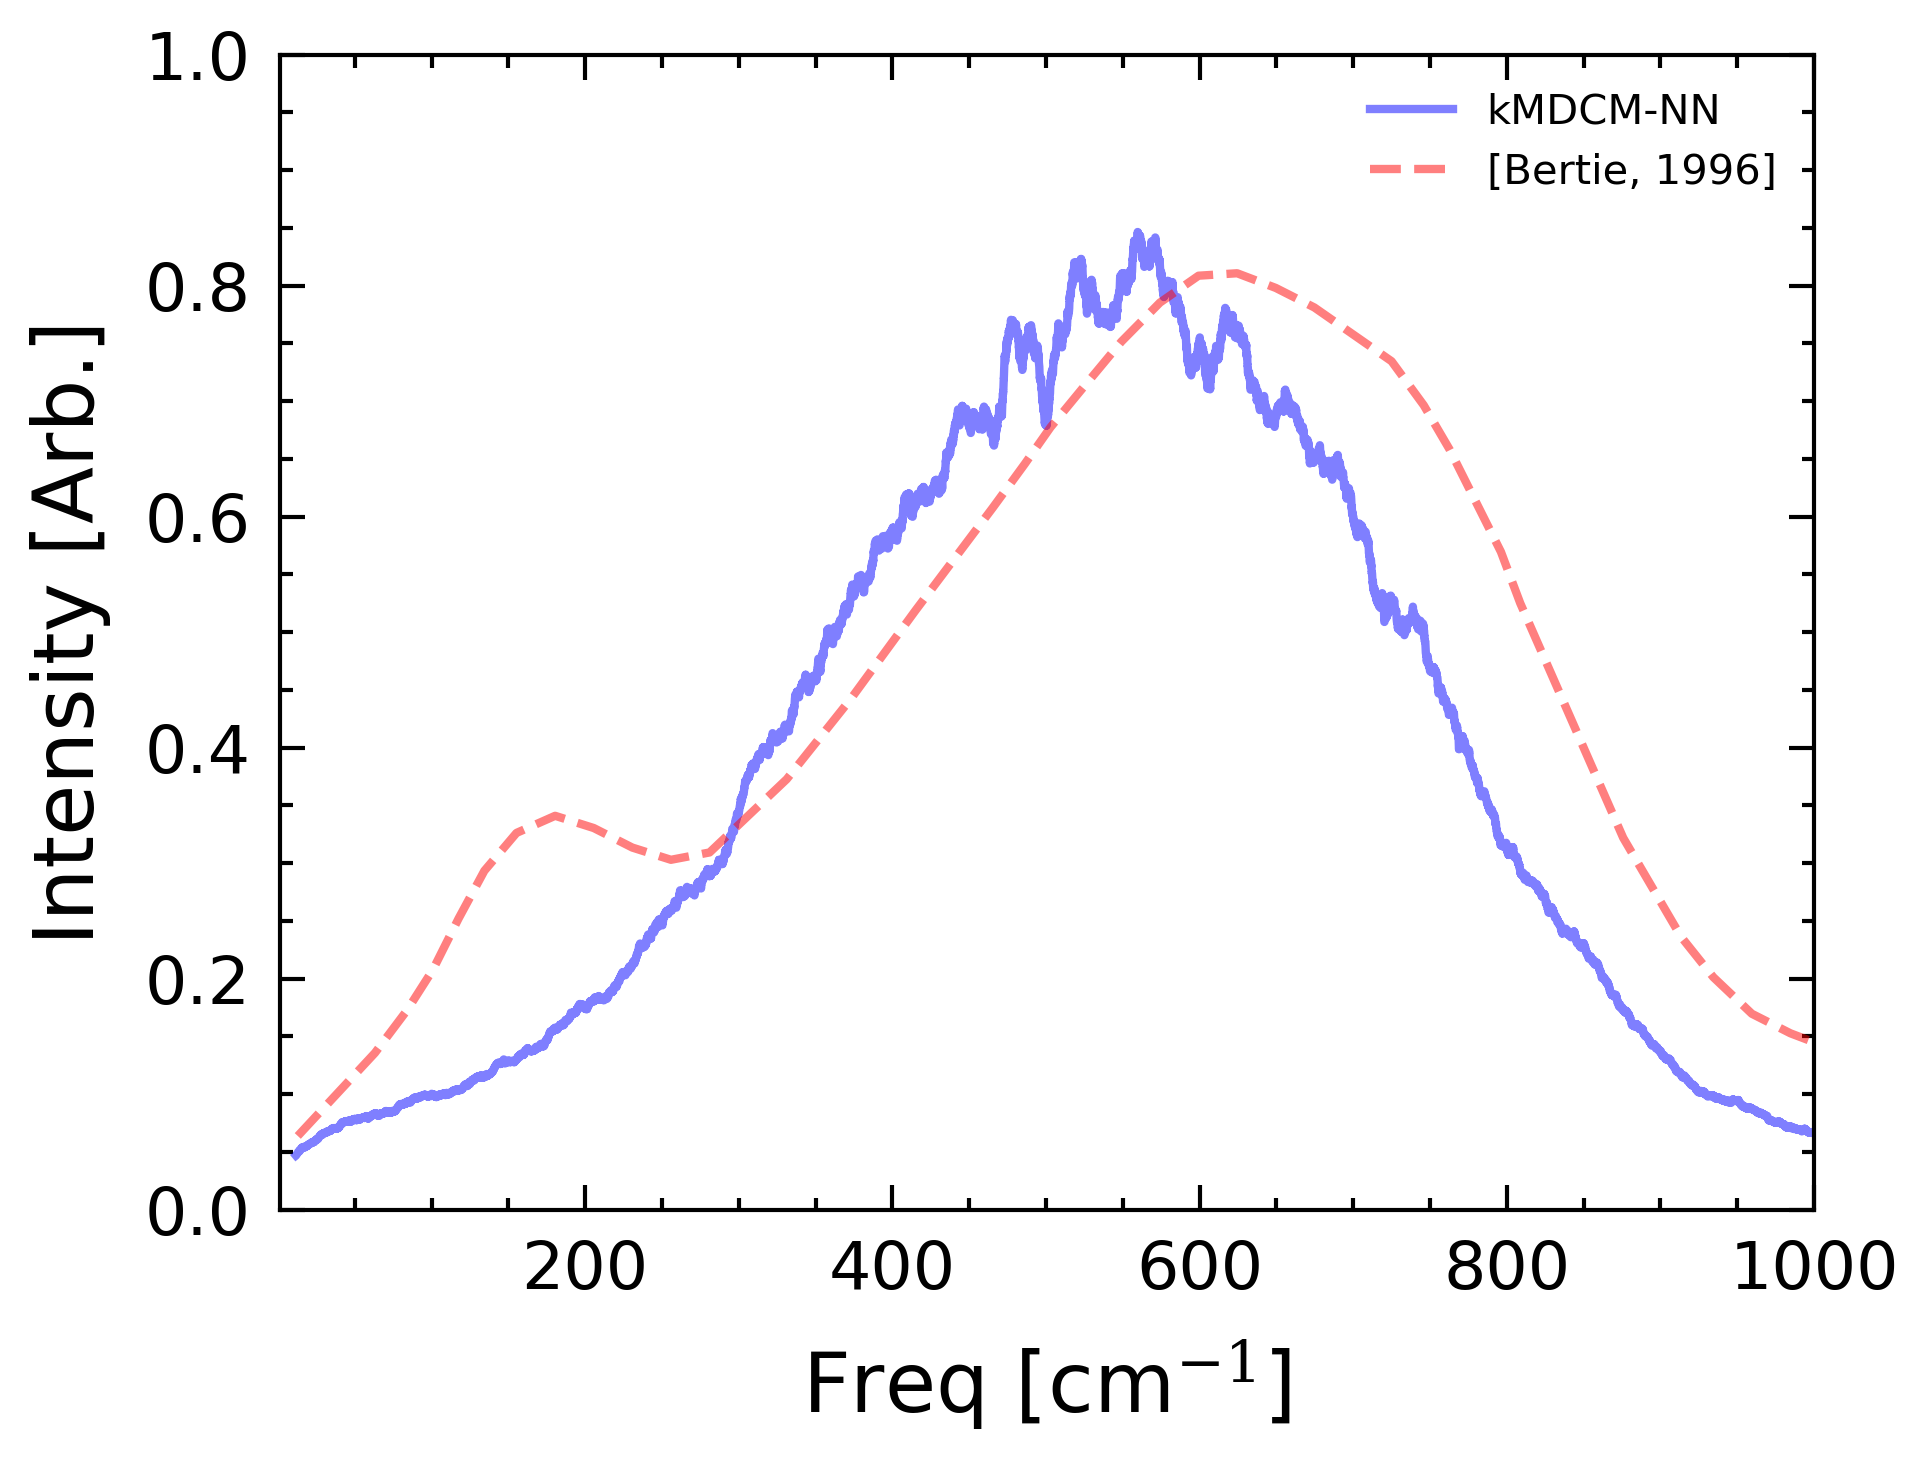

In [505]:


# ir_df.rolling(10).mean()[::100].plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

# _df.plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

plt.xlim(0,4000)

plt.plot(freq, intensity, color="blue", 
                            label="kMDCM-NN", alpha=0.5)



# plt.plot(freq, intensity*0.5, color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

plt.xlabel("Freq [cm$^{-1}$]", fontsize=FONTSIZE)
plt.ylabel("Intensity [Arb.]", fontsize=FONTSIZE)

# xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
# x, y = xy.T
# plt.plot(x, 
#          y*0.25+0.085, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
# plt.ylim(0, 0.5)
# plt.plot(water_exp_spectrum[0], np.array(water_exp_spectrum[1])*0.5, label="Exp.")

plt.xlim(1, 1000)

xy = np.array([[float(x) for x in _.split()] for _ in exp.split("\n")])
x, y = xy.T
plt.plot(x, y*3.5, label="[Bertie, 1996]", color="r", linestyle="--", alpha=0.5)
plt.ylim(0, 1)



plt.legend(fontsize=FONTSIZE/2)

plt.savefig("kNN-ir.pdf", bbox_inches="tight")

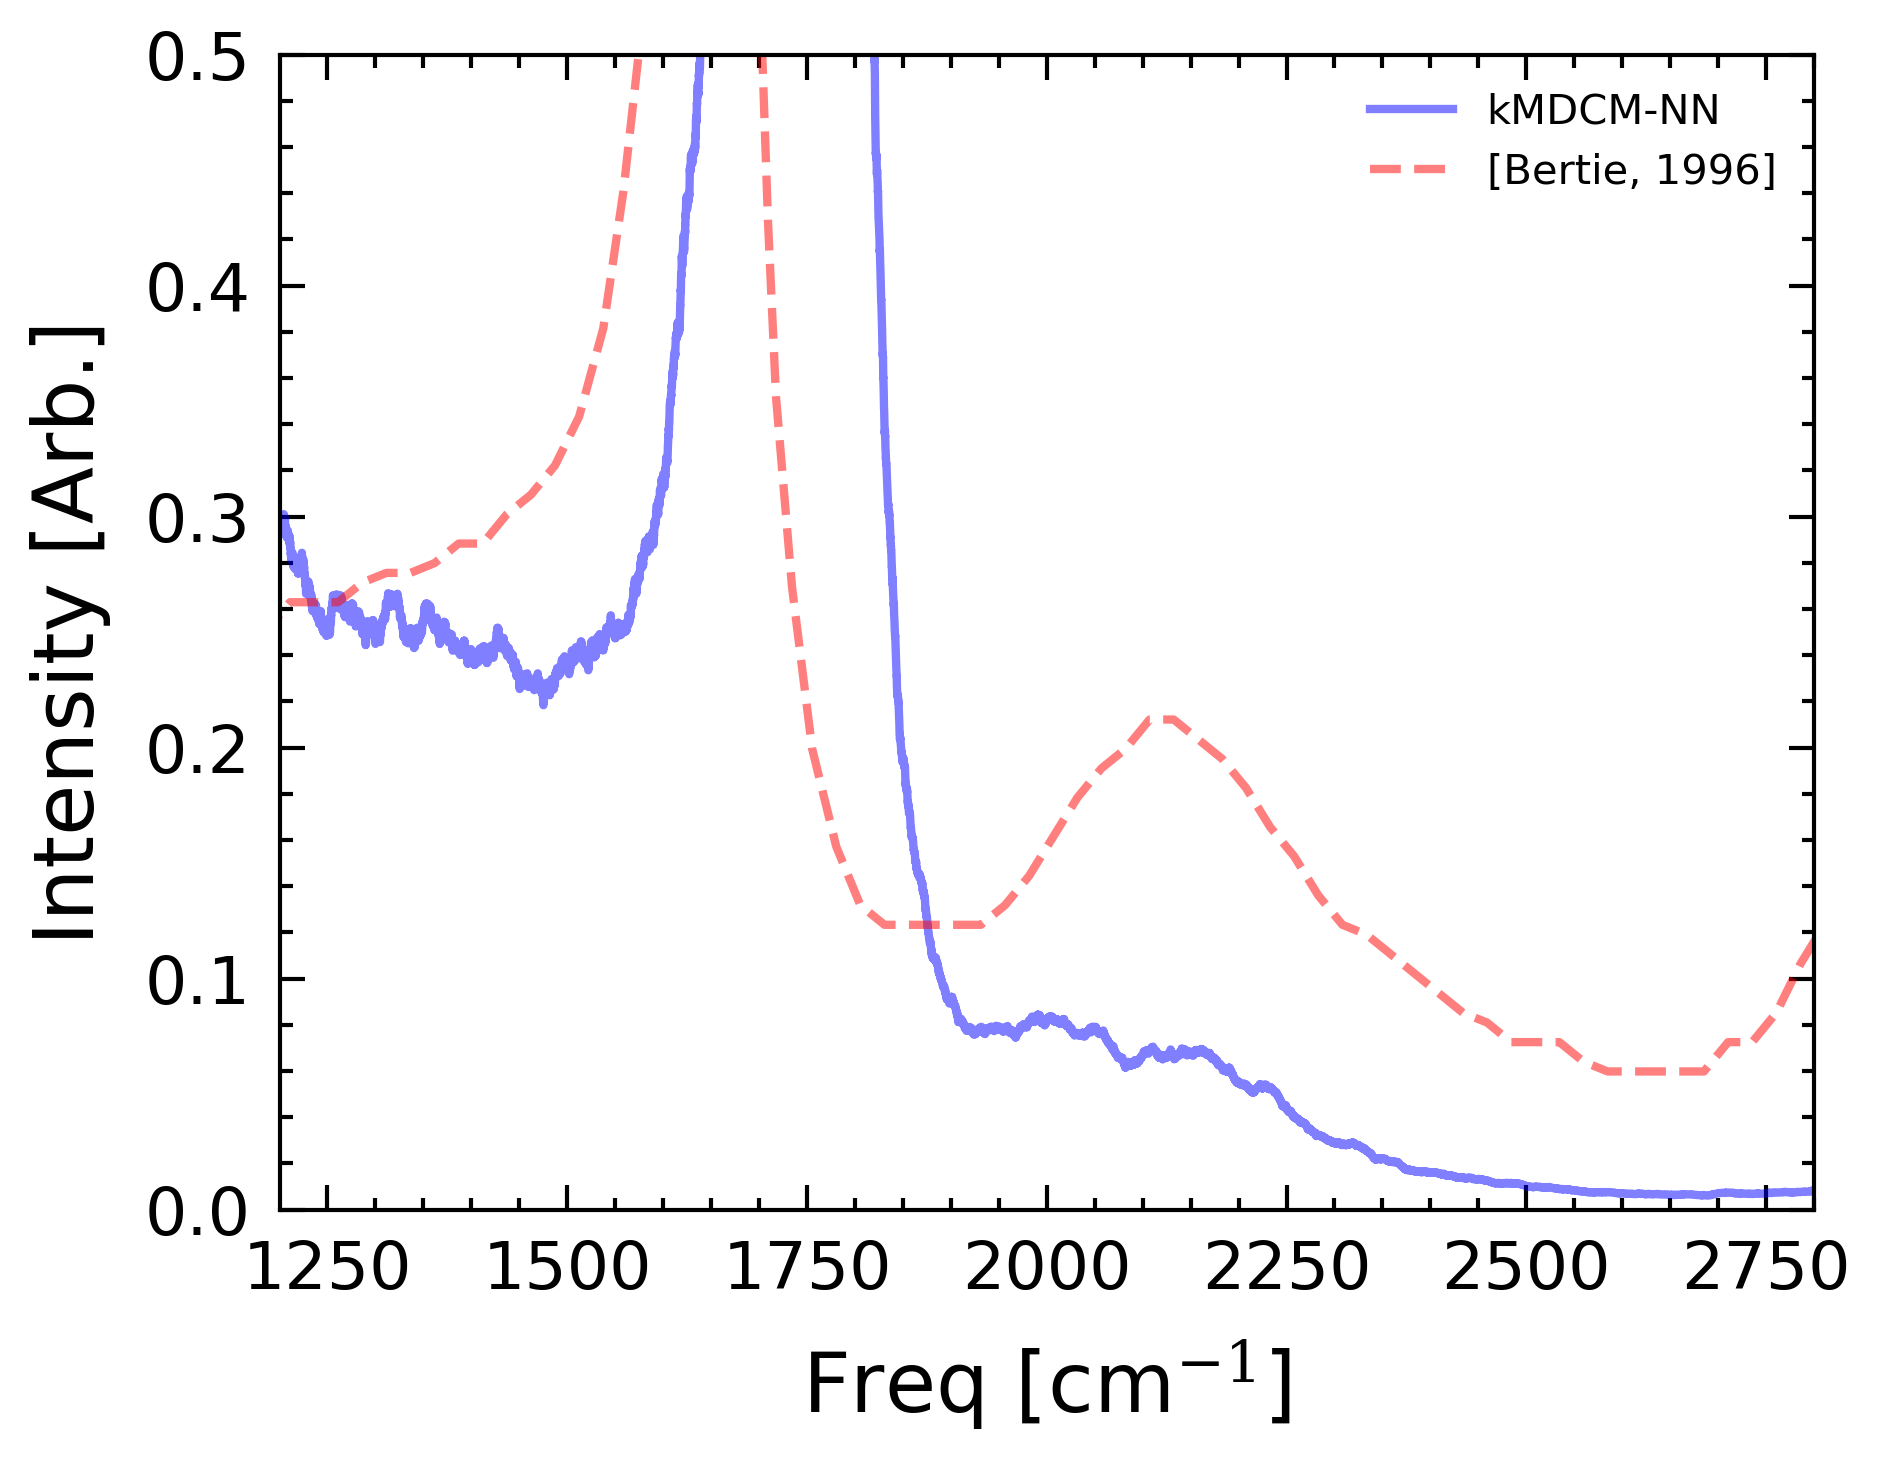

In [538]:
# ir_df.rolling(10).mean()[::100].plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

# _df.plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)



plt.plot(freq, intensity*7, color="blue", 
                            label="kMDCM-NN", alpha=0.5)



# plt.plot(freq, intensity*0.5, color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

plt.xlabel("Freq [cm$^{-1}$]", fontsize=FONTSIZE)
plt.ylabel("Intensity [Arb.]", fontsize=FONTSIZE)

# xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
# x, y = xy.T
# plt.plot(x, 
#          y*0.25+0.085, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
# plt.ylim(0, 0.5)
# plt.plot(water_exp_spectrum[0], np.array(water_exp_spectrum[1])*0.5, label="Exp.")

# plt.xlim(1, 1000)

xy = np.array([[float(x) for x in _.split()] for _ in exp.split("\n")])
x, y = xy.T
plt.plot(x, y*7, label="[Bertie, 1996]", color="r", linestyle="--", alpha=0.5)
# plt.ylim(0, 1)

plt.xlim(1200,2800)
plt.ylim(0, 0.5)
plt.legend(fontsize=FONTSIZE/2)
# plt.axvline(1646, color="b",linestyle="-", alpha=0.5)

plt.savefig("kNN-ir.pdf", bbox_inches="tight")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


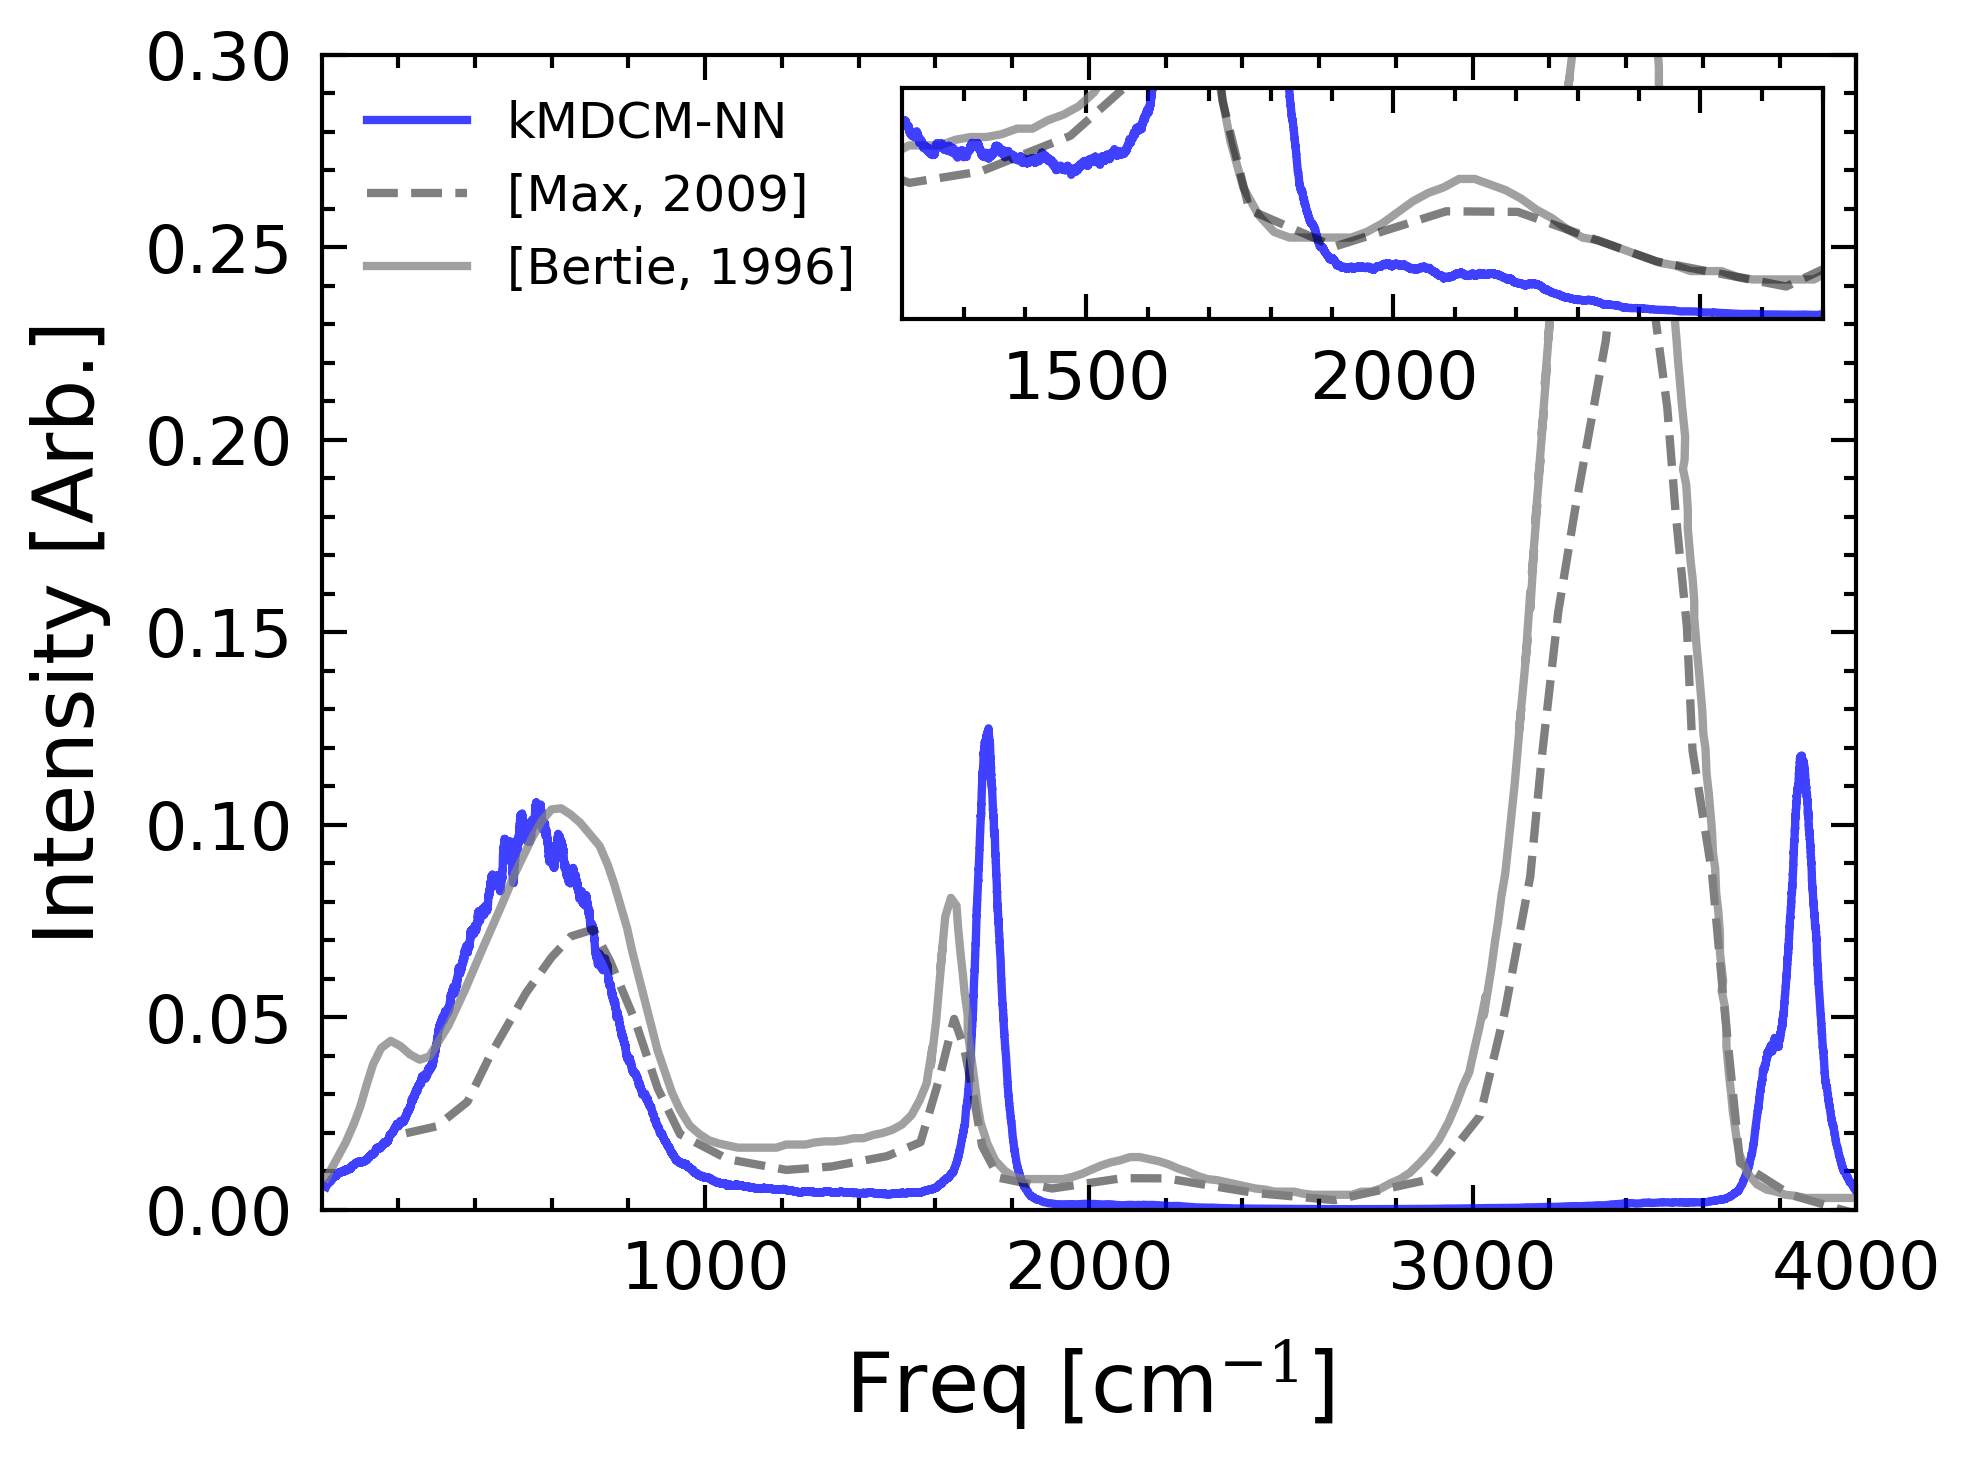

In [585]:


# ir_df.rolling(10).mean()[::100].plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

# _df.plot("freq", "Computed", color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

plt.xlim(0,4000)

plt.plot(freq, intensity*0.125, color="blue", 
                            label="kMDCM-NN", alpha=0.75)



# plt.plot(freq, intensity*0.5, color="blue", 
#                             label="kMDCM-NN", alpha=0.5)

plt.xlabel("Freq [cm$^{-1}$]", fontsize=FONTSIZE)
plt.ylabel("Intensity [Arb.]", fontsize=FONTSIZE)

xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
x, y = xy.T
plt.plot(x, 
         y*0.15+0.05, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
# plt.ylim(0, 0.5)
# plt.plot(water_exp_spectrum[0], np.array(water_exp_spectrum[1])*0.75, alpha=0.5, 
#          color="goldenrod", label="[NIST, 1969]",  linestyle="-")

plt.xlim(1, 4000)

xy = np.array([[float(x) for x in _.split()] for _ in exp.split("\n")])
x, y = xy.T
plt.plot(x, y*0.45, label="[Bertie, 1996]", color="gray", linestyle="-", alpha=0.75)
plt.ylim(0, 0.3)

ax = plt.gca()

plt.legend(fontsize=6, loc=2)
# plt.axvline(1646, color="b",linestyle="--", alpha=0.5)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_inset = inset_axes(ax, width="60%", height="20%")
ax_inset.plot(x, y*7,  color="gray", linestyle="-", alpha=0.75)
ax_inset.plot(freq, intensity*7, color="blue", 
                            label="kMDCM-NN", alpha=0.75)
xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
x, y = xy.T
ax_inset.plot(x, 
         y*3+1, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)

ax_inset.set_xlim(1200,2700)
ax_inset.set_ylim(0,0.35)
ax_inset.set_yticks([])
ax_inset.set_xticks([1500,2000,2500], [1500,2000,""])
plt.savefig("kNN-ir.pdf", bbox_inches="tight")



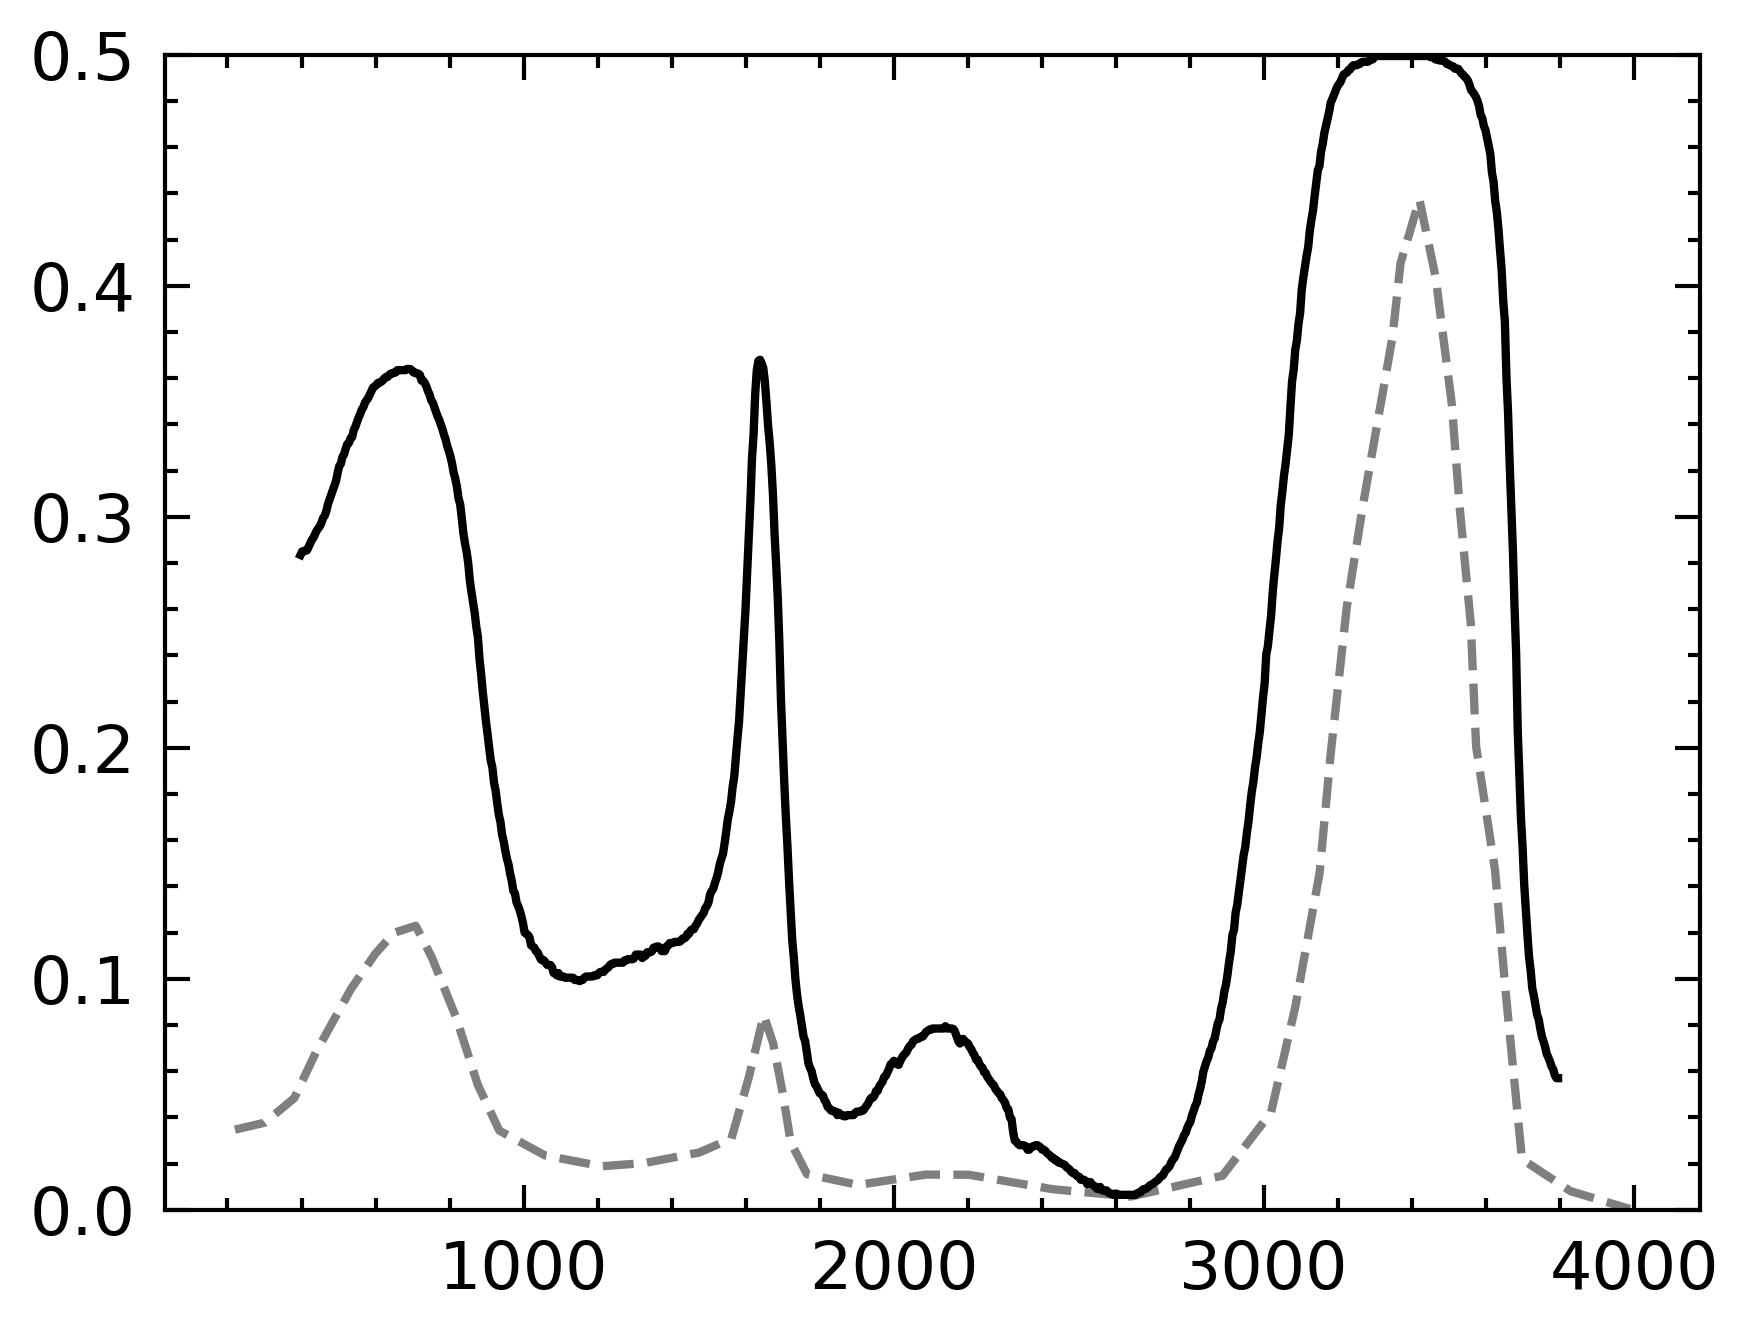

In [430]:
xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
x, y = xy.T
plt.plot(x, 
         y*0.25+0.085, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
plt.ylim(0, 0.5)
plt.plot(water_exp_spectrum[0], np.array(water_exp_spectrum[1])*0.5, label="Exp.")

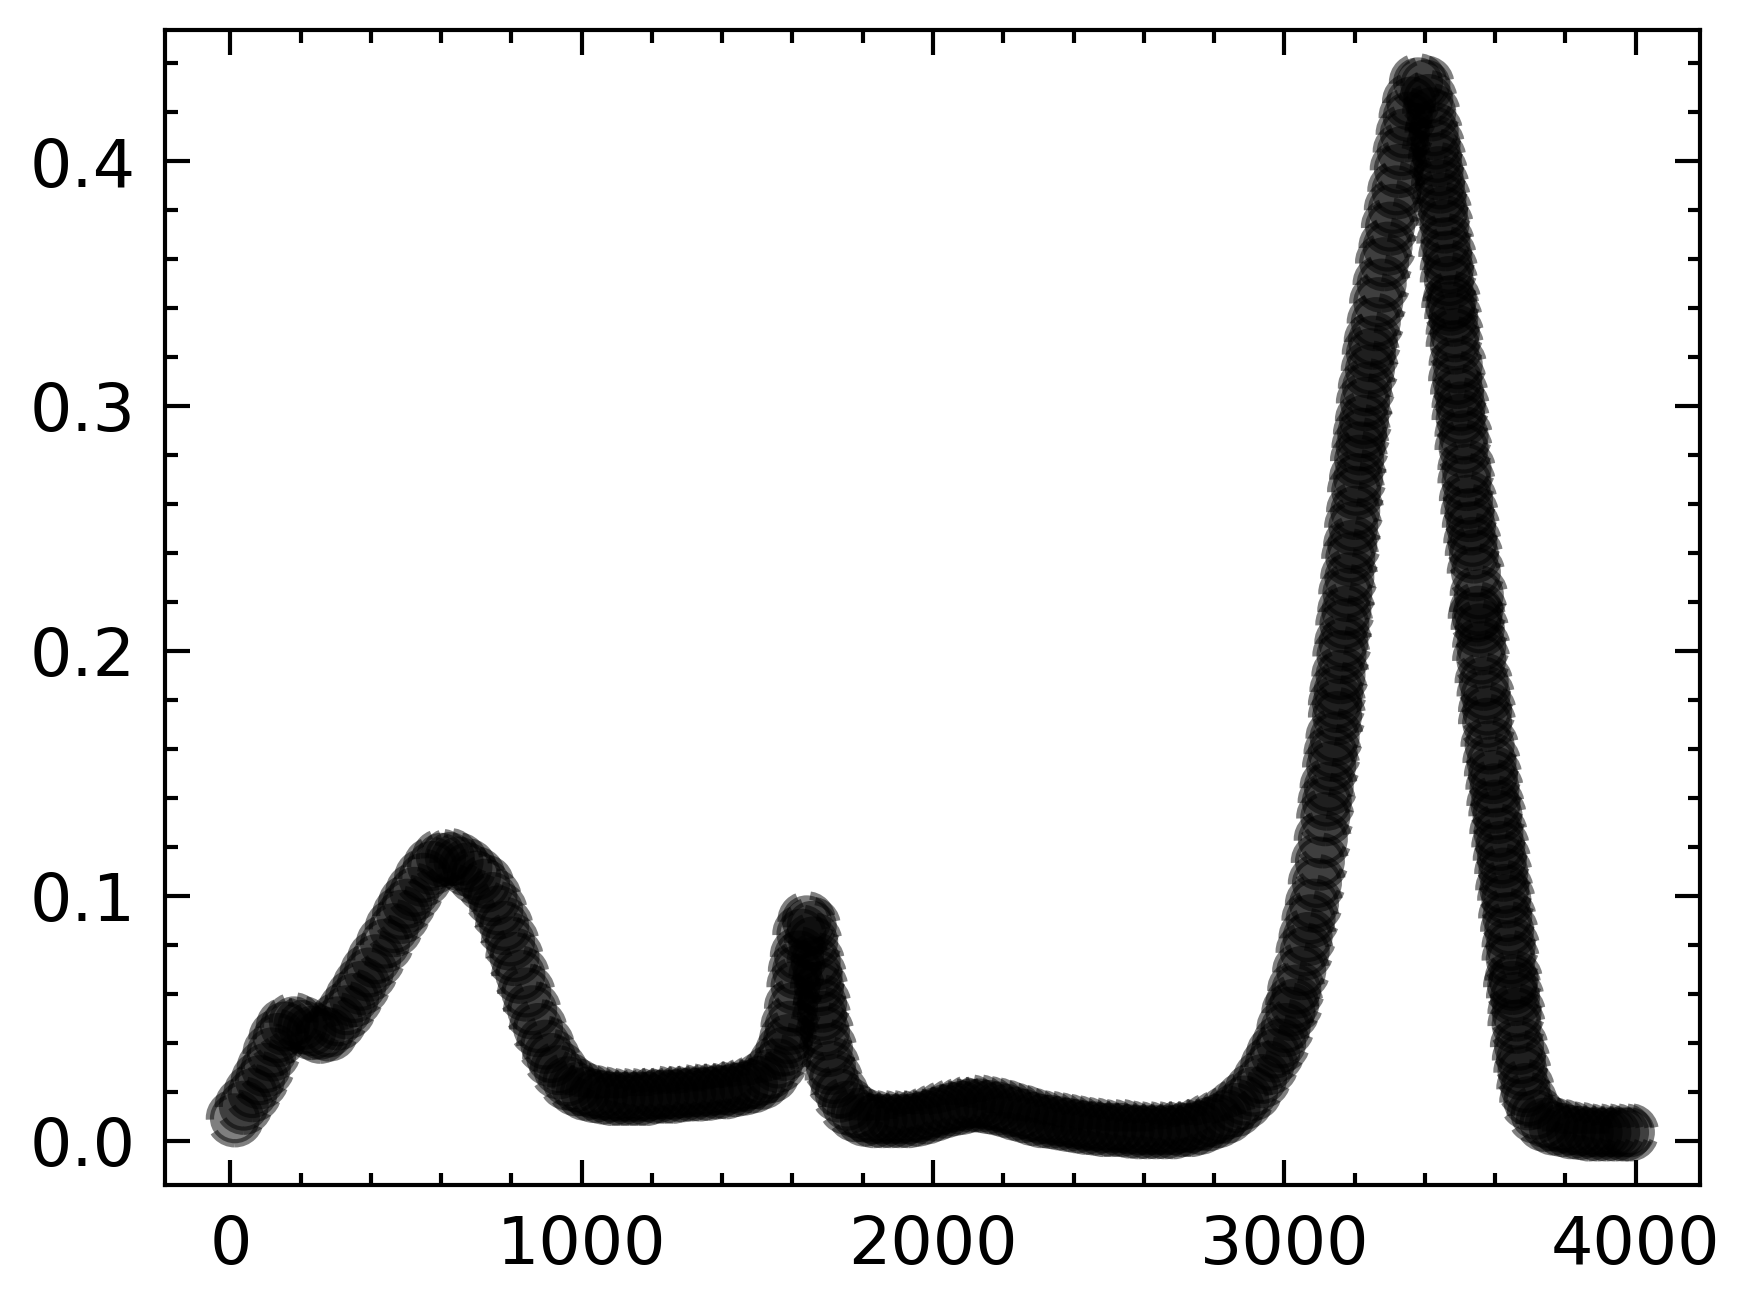

In [392]:
# xy = np.array([[float(x[:-1]) for x in _.split()] for _ in chapados.split("\n")])
# x, y = xy.T
# plt.plot(x, 
#          y*0.25+0.05, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
# plt.ylim(0, 0.5)

xy = np.array([[float(x) for x in _.split()] for _ in exp.split("\n")])
x, y = xy.T
plt.scatter(x, y*0.5, label="[Max, 2009]", color="k", linestyle="--", alpha=0.5)
# plt.ylim(0, 0.5)

In [393]:
xy = np.array([[float(x) for x in _.split()] for _ in exp.split("\n")])
xy

array([[1.28968254e+01, 1.82162403e-02],
       [3.80291005e+01, 2.84936999e-02],
       [6.31613757e+01, 3.87711595e-02],
       [8.41049383e+01, 4.93508973e-02],
       [1.00859788e+02, 5.93260787e-02],
       [1.17614638e+02, 7.20217640e-02],
       [1.34369489e+02, 8.38106147e-02],
       [1.55313051e+02, 9.31812397e-02],
       [1.80445326e+02, 9.74131348e-02],
       [2.05577601e+02, 9.43903526e-02],
       [2.30709877e+02, 8.95539010e-02],
       [2.55842152e+02, 8.65311187e-02],
       [2.80974427e+02, 8.83447881e-02],
       [3.06106702e+02, 9.74131348e-02],
       [3.31238977e+02, 1.06481481e-01],
       [3.52182540e+02, 1.16456663e-01],
       [3.73126102e+02, 1.26431844e-01],
       [3.94069665e+02, 1.37313860e-01],
       [4.15013228e+02, 1.48195876e-01],
       [4.40145503e+02, 1.60891562e-01],
       [4.65277778e+02, 1.73587247e-01],
       [4.86221340e+02, 1.84469263e-01],
       [5.02976190e+02, 1.93537610e-01],
       [5.23919753e+02, 2.03210513e-01],
       [5.490520

In [394]:
water_exp_spectrum[1]//100

TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [ ]:
# psf_path = "/home/boittier/pcbach/kmdcm_nn_water1/water2000.psf"
# dcd_path = "/home/boittier/pcbach/kmdcm_nn_water1/water.2000.nve.ir.dcd"
# timestep = 0.0002
# save_freq = 1
# effective_timestep = timestep * save_freq

# dipole_dcd(f"test_", psf_path, dcd_path, effective_timestep=effective_timestep, nsmooth=1)

In [ ]:
with open("/home/boittier/pcbehome/kmdcm_nn_water1/ECONS") as f:
    lines = f.readlines()


In [ ]:
ETOT = [float(_[27:41]) for _ in lines]

In [ ]:
plt.hist(ETOT - np.mean(ETOT))

In [ ]:
plt.plot(np.arange(len(ETOT)) * 0.2, ETOT - np.mean(ETOT))

In [ ]:
847000 * .2

In [ ]:
water_rdf_1 = """2.4615076480275357 0.059468174017968334
2.512692313398513 0.3882072509136556
2.5574974407667312 1.423799138515099
2.5603163063958574 1.1114688268079047
2.589246769431628 1.9059735224445984
2.602945467313522 2.388157797130691
2.6548719394290066 2.6347046867350117
2.6890939572422585 2.8429051130266214
2.7816714389567228 2.5853201390640375
2.801551859709508 2.3825695196554055
2.8774634165640496 1.9715690201721972
2.9164824513251135 1.6482599686463002
2.992047831698885 1.2756158232323962
3.1762631732514377 0.8645559792096273
3.4116631801749673 0.7822352120825458
3.717534827826654 0.8916566522756137
4.0769154686487745 1.072281649184752
4.563787961960149 1.1268093902843077
5.197439283117961 0.9182430059987414
5.504695636692729 0.874239029914591
6.099575192004312 0.9615843013911327
6.658353485749892 1.0489493543808615
7.2905706472016565 0.9992878655252708
7.88648873195555 0.971564074793899
8.698618755841729 0.9875574282054682
9.330341379463821 0.992690730877456
10.449431034226963 0.9975569831214215
11.31596021937698 0.9861232684994214
"""

water_rdf_2 = """2.412776412776413 0.03828650785172538
2.515970515970516 0.438436064523021
2.5454545454545454 1.142826621087491
2.633906633906634 1.9951287255635082
2.751842751842752 2.482256169212691
2.86977886977887 2.065035786774917
2.9729729729729732 1.4999679521418652
3.194103194103194 0.9437666915927785
3.385749385749386 0.8483922657835701
3.8574938574938575 0.9882063882063881
4.211302211302211 1.0582843713278498
4.535626535626536 1.0500587544065805
4.88943488943489 1.0157889114410854
5.213759213759214 0.9988676423459031
5.523341523341523 0.9471423993163122
5.803439803439803 0.9388526866787736
6.083538083538084 0.9653455827368871
6.378378378378379 1.0179468005554961
6.658476658476658 1.0444396966136096
6.968058968058967 1.036192714453584
7.616707616707616 1.0110458284371329
8.132678132678132 1.0030979596196985
8.737100737100738 1.0039739344087169
9.533169533169533 0.9964320051276572
9.93120393120393 1.01440017092191
"""


def plot_rdf_exp(ax, shift=0, c="k", lw=1, linestyle="--", marker="o"):
    # exp. data
    ex = []
    ey = []
    for _ in water_rdf_1.split("\n"):
        if _:
            ex.append(float(_.split(" ")[0]))
            ey.append(float(_.split(" ")[1]) + shift)

    ax.plot(
        ex,
        ey,
        linestyle,
        fillstyle="none",
        marker=marker,
        c=c,
        label="Exp. 1",
        linewidth=lw,
    )
    # exp. data
    ex = []
    ey = []
    for _ in water_rdf_2.split("\n"):
        if _:
            ex.append(float(_.split(" ")[0]))
            ey.append(float(_.split(" ")[1]) + shift)

    ax.plot(
        ex,
        ey,
        linestyle,
        fillstyle="none",
        c=c,
        marker=marker,
        label="Exp. 2",
        linewidth=lw,
    )
    return ax

In [43]:
exp = """1.289682539682530660e+01 1.821624029527812993e-02
3.802910052910044669e+01 2.849369988545236154e-02
6.316137566137570047e+01 3.877115947562659315e-02
8.410493827160496494e+01 4.935089728904151762e-02
1.008597883597883538e+02 5.932607865597550045e-02
1.176146384479718563e+02 7.202176403207327660e-02
1.343694885361552451e+02 8.381061473844964027e-02
1.553130511463845096e+02 9.318123965890268146e-02
1.804453262786596497e+02 9.741313478426882888e-02
2.055776014109347898e+02 9.439035255186456475e-02
2.307098765432100436e+02 8.955390098001769772e-02
2.558421516754851837e+02 8.653111874761343358e-02
2.809744268077603238e+02 8.834478808705603647e-02
3.061067019400354638e+02 9.741313478426882888e-02
3.312389770723106039e+02 1.064814814814813992e-01
3.521825396825398684e+02 1.164566628484153821e-01
3.731261022927692466e+02 1.264318442153493649e-01
3.940696649029985110e+02 1.373138602520045382e-01
4.150132275132277755e+02 1.481958762886597114e-01
4.401455026455030293e+02 1.608915616647574875e-01
4.652777777777780557e+02 1.735872470408552637e-01
4.862213403880073201e+02 1.844692630775104369e-01
5.029761904761908227e+02 1.935376097747231183e-01
5.239197530864200871e+02 2.032105129184166303e-01
5.490520282186953409e+02 2.146970854015527452e-01
5.741843033509703673e+02 2.243699885452461462e-01
5.993165784832456211e+02 2.310201094565355051e-01
6.244488536155206475e+02 2.316246659030163357e-01
6.495811287477959013e+02 2.279973272241312410e-01
6.747134038800709277e+02 2.231608756522844850e-01
6.998456790123461815e+02 2.165107547409952371e-01
7.249779541446214353e+02 2.098606338297058782e-01
7.459215167548506997e+02 1.989786177930507050e-01
7.626763668430339749e+02 1.880966017563955317e-01
7.794312169312174774e+02 1.754009163802977556e-01
7.961860670194009799e+02 1.627052310041999794e-01
8.087522045855384931e+02 1.500095456281022033e-01
8.255070546737219956e+02 1.355001909125619353e-01
8.422619047619052708e+02 1.209908361970217783e-01
8.590167548500887733e+02 1.064814814814813992e-01
8.757716049382722758e+02 9.197212676594102021e-02
8.967151675485015403e+02 7.836960672012205364e-02
9.134700176366850428e+02 6.748759068346688039e-02
9.344135802469143073e+02 5.751240931653289756e-02
9.595458553791893337e+02 4.844406261932032720e-02
9.846781305114645875e+02 4.360761104747346018e-02
1.009810405643739614e+03 3.998027236858847644e-02
1.034942680776014868e+03 3.816660302914587355e-02
1.060074955908290121e+03 3.695749013618421230e-02
1.085207231040565148e+03 3.574837724322255106e-02
1.110339506172840402e+03 3.574837724322255106e-02
1.135471781305115428e+03 3.574837724322255106e-02
1.160604056437390682e+03 3.574837724322255106e-02
1.185736331569665708e+03 3.574837724322255106e-02
1.210868606701940962e+03 3.756204658266515395e-02
1.236000881834215988e+03 3.756204658266515395e-02
1.261133156966491242e+03 3.756204658266515395e-02
1.286265432098766496e+03 3.877115947562659315e-02
1.311397707231041522e+03 3.937571592210753479e-02
1.336529982363316776e+03 3.937571592210753479e-02
1.361662257495591803e+03 3.998027236858847644e-02
1.386794532627867056e+03 4.118938526155013768e-02
1.411926807760142083e+03 4.118938526155013768e-02
1.437059082892417109e+03 4.300305460099274057e-02
1.462191358024692590e+03 4.421216749395417978e-02
1.487323633156967617e+03 4.602583683339678267e-02
1.512455908289242643e+03 4.904861906580126885e-02
1.537588183421518124e+03 5.448962708412885547e-02
1.558531746031747161e+03 6.295341733486048419e-02
1.576682833627279479e+03 7.262632047855421824e-02
1.592041446208114166e+03 9.378579610538362310e-02
1.587852733686068177e+03 8.290378006872844985e-02
1.601815108759554505e+03 1.088997072674049438e-01
1.608796296296297669e+03 1.264318442153493649e-01
1.618569958847738008e+03 1.512186585210638645e-01
1.612985008818343204e+03 1.391275295914470300e-01
1.625551146384481171e+03 1.690530736922488675e-01
1.640211640211641452e+03 1.799350897289040407e-01
1.654872134038802187e+03 1.754009163802977556e-01
1.659060846560847722e+03 1.627052310041999794e-01
1.666042034097590886e+03 1.463822069492172195e-01
1.671626984126985235e+03 1.355001909125619353e-01
1.675815696649031224e+03 1.255250095456279524e-01
1.684193121693123203e+03 1.119224894998089859e-01
1.684193121693123203e+03 1.019473081328750030e-01
1.692570546737214727e+03 8.925162275677722690e-02
1.700947971781306251e+03 7.564910271095826033e-02
1.709325396825398229e+03 6.113974799541810334e-02
1.717702821869489753e+03 5.025773195876270805e-02
1.734457671957673256e+03 3.846888125238634437e-02
1.755401234567902748e+03 2.849369988545236154e-02
1.780533509700177774e+03 2.244813542064383327e-02
1.805665784832452800e+03 1.882079674175884954e-02
1.830798059964727827e+03 1.761168384879718829e-02
1.855930335097003308e+03 1.761168384879718829e-02
1.881062610229278334e+03 1.761168384879718829e-02
1.906194885361553361e+03 1.761168384879718829e-02
1.931327160493828842e+03 1.761168384879718829e-02
1.956459435626103868e+03 1.882079674175884954e-02
1.981591710758378895e+03 2.063446608120123038e-02
2.006723985890653921e+03 2.305269186712477492e-02
2.031856261022929402e+03 2.547091765304831945e-02
2.056988536155204201e+03 2.728458699249070030e-02
2.082120811287479228e+03 2.849369988545236154e-02
2.107253086419755164e+03 3.030736922489496443e-02
2.132385361552030190e+03 3.030736922489496443e-02
2.157517636684305216e+03 2.909825633193330319e-02
2.182649911816580243e+03 2.788914343897141990e-02
2.207782186948855269e+03 2.607547409952881701e-02
2.232914462081130296e+03 2.365724831360571656e-02
2.258046737213405322e+03 2.184357897416311367e-02
2.283179012345680349e+03 1.942535318823979118e-02
2.308311287477956284e+03 1.761168384879718829e-02
2.333443562610231311e+03 1.700712740231624664e-02
2.358575837742506337e+03 1.579801450935458540e-02
2.383708112874781364e+03 1.458890161639292415e-02
2.408840388007056390e+03 1.337978872343126291e-02
2.433972663139331416e+03 1.217067583046960166e-02
2.459104938271606443e+03 1.156611938398866002e-02
2.484237213403882379e+03 1.035700649102699877e-02
2.509369488536157405e+03 1.035700649102699877e-02
2.534501763668432432e+03 1.035700649102699877e-02
2.559634038800707458e+03 9.147893598065337528e-03
2.584766313932982484e+03 8.543337151584395883e-03
2.609898589065257511e+03 8.543337151584395883e-03
2.635030864197532537e+03 8.543337151584395883e-03
2.660163139329808473e+03 8.543337151584395883e-03
2.685295414462083500e+03 8.543337151584395883e-03
2.710427689594358526e+03 1.035700649102699877e-02
2.735559964726633552e+03 1.035700649102699877e-02
2.760692239858908579e+03 1.217067583046960166e-02
2.785824514991183605e+03 1.519345806287364375e-02
2.810956790123458632e+03 1.761168384879718829e-02
2.836089065255734567e+03 2.123902252768217203e-02
2.861221340388009594e+03 2.668003054600975865e-02
2.886353615520284620e+03 3.272559501081828692e-02
2.911485890652559647e+03 3.998027236858847644e-02
2.936618165784834673e+03 5.025773195876270805e-02
2.957561728395064165e+03 6.113974799541810334e-02
2.974316578483247213e+03 7.111492936235186413e-02
2.991071428571431170e+03 7.927644138984346611e-02
3.003637566137568683e+03 9.197212676594102021e-02
3.017599941211055011e+03 1.052723685885197380e-01
3.034354791299238059e+03 1.234090619829451008e-01
3.028769841269843710e+03 1.119224894998089859e-01
3.048317166372724387e+03 1.385229731449660884e-01
3.058090828924164271e+03 1.545437189767085995e-01
3.066468253968256249e+03 1.663325696830850742e-01
3.074845679012348228e+03 1.808419243986253422e-01
3.084619341563789021e+03 1.935376097747231183e-01
3.092996766607880090e+03 2.104651902761867088e-01
3.101374191651972069e+03 2.279973272241312410e-01
3.109751616696064048e+03 2.461340206185566037e-01
3.116732804232806302e+03 2.642707140129819665e-01
3.126506466784247095e+03 2.890575283186966882e-01
3.120921516754852746e+03 2.769663993890797427e-01
3.133487654320990259e+03 3.059851088201602787e-01
3.143261316872431053e+03 3.295628102329132281e-01
3.137676366843035794e+03 3.168671248568155629e-01
3.150242504409173307e+03 3.567678503245512722e-01
3.150242504409173307e+03 3.467926689576172894e-01
3.160016166960614100e+03 3.803455517373042216e-01
3.154431216931219751e+03 3.676498663612065565e-01
3.168393592004706079e+03 4.069460353824614351e-01
3.162808641975310820e+03 3.966685757922870925e-01
3.176771017048797148e+03 4.329419625811378181e-01
3.171186067019402799e+03 4.220599465444825338e-01
3.185148442092889127e+03 4.601470026727758622e-01
3.179563492063494778e+03 4.474513172966780861e-01
3.193525867136981105e+03 4.867474863179330757e-01
3.187940917107585847e+03 4.764700267277586221e-01
3.201903292181073084e+03 5.145570828560518395e-01
3.196318342151677825e+03 5.018613974799541744e-01
3.210280717225164153e+03 5.411575665012090530e-01
3.204695767195769804e+03 5.308801069110347104e-01
3.217261904761907317e+03 5.671534936998854359e-01
3.213073192239861783e+03 5.562714776632301517e-01
3.227035567313348110e+03 5.889175257731957824e-01
3.221450617283952852e+03 5.780355097365406092e-01
3.235412992357439180e+03 6.155180094183529960e-01
3.229828042328044830e+03 6.034268804887361615e-01
3.243790417401531158e+03 6.300273641338933750e-01
3.252167842445623137e+03 6.536050655466463244e-01
3.246582892416227878e+03 6.433276059564718707e-01
3.260545267489714206e+03 6.687189767086674230e-01
3.267526455026457370e+03 6.850420007636501829e-01
3.277300117577898163e+03 7.001559119256712815e-01
3.284281305114641327e+03 7.176880488736159247e-01
3.294054967666081211e+03 7.303837342497135898e-01
3.301036155202824375e+03 7.467067583046964607e-01
3.309413580246916354e+03 7.612161130202366177e-01
3.319187242798356237e+03 7.763300241822578274e-01
3.326168430335099401e+03 7.938621611302023595e-01
3.334545855379191380e+03 8.083715158457426275e-01
3.342923280423283359e+03 8.228808705612828955e-01
3.351300705467374428e+03 8.364833906071018621e-01
3.361074368018815221e+03 8.488767977599592784e-01
3.380621693121695898e+03 8.645952653684612077e-01
3.401565255731925390e+03 8.627815960290186048e-01
3.409942680776016459e+03 8.509927453226422411e-01
3.418320105820108438e+03 8.401107292859870679e-01
3.425301293356851602e+03 8.246945399007254984e-01
3.430886243386245951e+03 8.138125238640702142e-01
3.435074955908292395e+03 8.029305078274149299e-01
3.439263668430337930e+03 7.920484917907597566e-01
3.443452380952383464e+03 7.811664757541045834e-01
3.447641093474429908e+03 7.702844597174494101e-01
3.451829805996475443e+03 7.594024436807942369e-01
3.456018518518520978e+03 7.485204276441389526e-01
3.458810993533218607e+03 7.340110729285986846e-01
3.464395943562612956e+03 7.231290568919435113e-01
3.468584656084659400e+03 7.122470408552882271e-01
3.468584656084659400e+03 7.022718594883543552e-01
3.476962081128750469e+03 6.868556701030927858e-01
3.472773368606704935e+03 6.814146620847651992e-01
3.481150793650796913e+03 6.723463153875524068e-01
3.485339506172842448e+03 6.596506300114546306e-01
3.485339506172842448e+03 6.496754486445207588e-01
3.493716931216934427e+03 6.342592592592591894e-01
3.492320693709585612e+03 6.215635738831614132e-01
3.497905643738979961e+03 6.106815578465062400e-01
3.502094356261025496e+03 5.997995418098510667e-01
3.502094356261025496e+03 5.898243604429170839e-01
3.510471781305117474e+03 5.762218403970981173e-01
3.510471781305117474e+03 5.653398243604428330e-01
3.518849206349209453e+03 5.490168003054600732e-01
3.518849206349209453e+03 5.381347842688047889e-01
3.523037918871254988e+03 5.236254295532645209e-01
3.527226631393301432e+03 5.127434135166093476e-01
3.531415343915346966e+03 5.018613974799541744e-01
3.535604056437392501e+03 4.891657121038563982e-01
3.539792768959438945e+03 4.788882525136819446e-01
3.545377718988833294e+03 4.643788977981416766e-01
3.553755144032925273e+03 4.462422044037163138e-01
3.552358906525576458e+03 4.329419625811378181e-01
3.548170194003530014e+03 4.275009545628101204e-01
3.556547619047621993e+03 4.184326078655975500e-01
3.560736331569667527e+03 4.039232531500571710e-01
3.560736331569667527e+03 3.930412371134019978e-01
3.567717519106410691e+03 3.749045437189766350e-01
3.573302469135805950e+03 3.640225276823214617e-01
3.577491181657851484e+03 3.513268423062236856e-01
3.577491181657851484e+03 3.413516609392897028e-01
3.584472369194594648e+03 3.229126893216239802e-01
3.590057319223988998e+03 3.096124474990453734e-01
3.594246031746034532e+03 2.987304314623902002e-01
3.598434744268080976e+03 2.878484154257349159e-01
3.601227219282777696e+03 2.745481736031564202e-01
3.606812169312172045e+03 2.660843833524245694e-01
3.609604644326869675e+03 2.515750286368841904e-01
3.615189594356264024e+03 2.406930126002290171e-01
3.619378306878309559e+03 2.298109965635738439e-01
3.623567019400356003e+03 2.189289805269185596e-01
3.626359494415052723e+03 2.056287387043400638e-01
3.631944444444447981e+03 1.971649484536082131e-01
3.634736919459144701e+03 1.826555937380678341e-01
3.640321869488539051e+03 1.717735777014126608e-01
3.644510582010585495e+03 1.590778923253148847e-01
3.644510582010585495e+03 1.481958762886597114e-01
3.652888007054676564e+03 1.318728522336768405e-01
3.648699294532631029e+03 1.264318442153493649e-01
3.657076719576723008e+03 1.173634975181365725e-01
3.661265432098768542e+03 1.046678121420387964e-01
3.661265432098768542e+03 9.469263077510481352e-02
3.668246619635511706e+03 7.746277205040086322e-02
3.673831569664906056e+03 6.658075601374568997e-02
3.678020282186951590e+03 5.660557464681170714e-02
3.686397707231043569e+03 4.300305460099274057e-02
3.694775132275135547e+03 3.212103856433734528e-02
3.715718694885365039e+03 2.123902252768217203e-02
3.740850970017640066e+03 1.458890161639292415e-02
3.765983245149915092e+03 1.156611938398866002e-02
3.791115520282190118e+03 1.035700649102699877e-02
3.816247795414465145e+03 8.543337151584395883e-03
3.841380070546740171e+03 7.938780705103676283e-03
3.866512345679015198e+03 6.729667812142015038e-03
3.891644620811291134e+03 6.729667812142015038e-03
3.916776895943566160e+03 6.729667812142015038e-03
3.941909171075841186e+03 6.729667812142015038e-03
3.967041446208116213e+03 6.729667812142015038e-03
3.983796296296299261e+03 6.729667812142015038e-03"""

In [44]:
chapados = """220.11661807580094, -0.2011305721852521
300.2915451895042, -0.18911267887743932
380.4664723032065, -0.146560434424587
438.775510204081, -0.06731355573854358
533.5276967930022, 0.0423786526606289
599.1253644314866, 0.10328711637326737
650.1457725947521, 0.13980370774263928
708.4548104956266, 0.15187501390959923
752.1865889212822, 0.09680635613023902
817.7842565597666, -0.007170676340328086
876.0932944606402, -0.12334364498252892
934.4023323615156, -0.20287539225068318
1058.3090379008745, -0.24592615672222973
1211.3702623906702, -0.2646206574232748
1327.98833819242, -0.25879865577637684
1473.7609329446059, -0.24083413081699323
1561.224489795918, -0.21662030133754673
1608.6005830903769, -0.10986580019139325
1648.6880466472303, -0.0030934947588621142
1674.1982507288612, -0.052010771593261396
1699.708454810495, -0.13756926980170459
1721.5743440233227, -0.22311886586695628
1765.3061224489793, -0.2781875236463174
1903.7900874635561, -0.29684641577459736
2086.0058309037895, -0.27897091224712334
2202.6239067055385, -0.2792557808292342
2428.5714285714275, -0.30423519462310544
2639.9416909620986, -0.3169652593861967
2887.7551020408155, -0.2809293837491378
3018.950437317784, -0.17132619678187488
3084.5481049562677, 0.011719671510917351
3150.1457725947516, 0.24362050163576932
3179.3002915451893, 0.4450760020474931
3223.0320699708454, 0.701457725947523
3266.763848396501, 0.8784501368704518
3346.9387755102034, 1.171384060712617
3368.8046647230317, 1.2995749226626314
3419.825072886297, 1.4093739567800947
3463.5568513119533, 1.274915986023636
3507.288629737609, 1.0549618320610694
3529.1545189504373, 0.8717023123316947
3558.3090379008745, 0.6762112478579221
3572.8862973760934, 0.4624351812698917
3623.9067055393584, 0.24857009324995083
3653.061224489795, 0.03475841808915536
3696.7930029154513, -0.2523713083924948
3827.988338192419, -0.30765361760843923
3988.338192419825, -0.33857966305388043"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with open("/home/boittier/pcbach/kmdcm_water_sim_rkhs1/rdf.dat") as f:
    lines = f.readlines()
    results = [[float(x) for x in _.split()] for _ in lines]
results = np.array(results)

with open("/home/boittier/pcbach/shake/shake-rdf.dat") as f:
    lines = f.readlines()
    Sresults = [[float(x) for x in _.split()] for _ in lines]
Sresults = np.array(Sresults)

In [ ]:
ax = plt.gca()
plot_rdf_exp(ax)
ax.plot(*results.T, label="kMDCM-RKHS")
ax.plot(*Sresults.T, label="TIP3 SHAKE", alpha=0.51)
plt.legend()
plt.ylabel("$g(r)$", fontsize=20)
plt.xlabel("r [$\mathrm{\AA}$]", fontsize=20)
plt.savefig("rdf_.pdf", bbox_inches="tight")
plt.xlim(0,10)
plt.ylim(0,3)
plt.axhline(1, color="k", alpha=0.1)
plt.savefig("kmdcm-rdf-231129.pdf", bbox_inches="tight")

In [211]:
y = np.arange(10)
x = np.arange(10)

In [215]:
ans = []
ans1 = []
for i in y:
    for j in x:
        print(i, j, i+2*np.pi*j, i+2*j)
        ans.append(i+2*np.pi*j)
        ans1.append(i+2*j)

0 0 0.0 0
0 1 6.283185307179586 2
0 2 12.566370614359172 4
0 3 18.84955592153876 6
0 4 25.132741228718345 8
0 5 31.41592653589793 10
0 6 37.69911184307752 12
0 7 43.982297150257104 14
0 8 50.26548245743669 16
0 9 56.548667764616276 18
1 0 1.0 1
1 1 7.283185307179586 3
1 2 13.566370614359172 5
1 3 19.84955592153876 7
1 4 26.132741228718345 9
1 5 32.41592653589793 11
1 6 38.69911184307752 13
1 7 44.982297150257104 15
1 8 51.26548245743669 17
1 9 57.548667764616276 19
2 0 2.0 2
2 1 8.283185307179586 4
2 2 14.566370614359172 6
2 3 20.84955592153876 8
2 4 27.132741228718345 10
2 5 33.41592653589793 12
2 6 39.69911184307752 14
2 7 45.982297150257104 16
2 8 52.26548245743669 18
2 9 58.548667764616276 20
3 0 3.0 3
3 1 9.283185307179586 5
3 2 15.566370614359172 7
3 3 21.84955592153876 9
3 4 28.132741228718345 11
3 5 34.41592653589793 13
3 6 40.69911184307752 15
3 7 46.982297150257104 17
3 8 53.26548245743669 19
3 9 59.548667764616276 21
4 0 4.0 4
4 1 10.283185307179586 6
4 2 16.566370614359172 

In [217]:
len(list(set(ans)))

100

In [218]:
len(list(set(ans1)))

28